# Exploratory Data Analysis - Ampcontrol

This report conducts a thorough Exploratory Data Analysis (EDA) of the charging events dataset.

### Running the Notebook
1. You can run the notebook from start to finish to generate visuals which is done by removing miscalculated charging events.
2. If you prefer to retain the miscalculated events, set remove_assumed_errors=False. (Cell. 9)
Note that this will require adding bin values in the Bivariate Visuals section before executing the code. (Cell. 25)

In [1]:
#### General ####
import pandas as pd
import numpy as np

#### Visualization ####
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#### Pre-processing ####
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Bayesian Modeling ####
import pymc as pm

import warnings
warnings.filterwarnings('ignore')

In [2]:
charging_events_df = pd.read_csv('charging_events_meter_reading.csv')

In [3]:
charging_events_df.head()

,Start Time,Meter Start (Wh),Meter End(Wh),Meter Total(Wh),Total Duration (s),Charger_name
0,24.08.2018 09:50,50,50.00,0.00,37,NaN
1,24.08.2018 09:51,50,50.00,0.00,38,NaN
2,24.08.2018 09:51,73,118.52,45.52,56,NaN
3,24.08.2018 09:53,105,116.66,11.66,76,NaN
4,24.08.2018 09:54,121,144.77,23.77,19,NaN


In [4]:
charging_events_df_copy = charging_events_df.copy()

## Data Pre-processing

In [5]:
class ChargingDataProcessor:
    def __init__(self, data_frame):
        self.df = data_frame

    def preprocess_data(self, remove_assumed_errors=False, remove_outliers=False):
        # Convert Watt-hour columns to kWh and drop the original watt columns
        watt_hour_cols = ['Meter Start (Wh)', 'Meter End(Wh)', 'Meter Total(Wh)']
        kwh_cols = ['Meter Start (kWh)', 'Meter End (kWh)', 'Meter Total (kWh)']
        
        self.df[kwh_cols] = self.df[watt_hour_cols] / 1000
        self.df.drop(columns=watt_hour_cols, inplace=True)

        # Convert duration from seconds to hours
        self.df['Total Duration (h)'] = self.df['Total Duration (s)'] / 3600
        self.df.drop(columns=['Total Duration (s)'], inplace=True)

        # Fill missing charger names with 'unknown'
        self.df['Charger_name'].fillna(value='unknown', inplace=True)

        if remove_assumed_errors:
            # Calculate the conditions
            condition1 = self._calculate_condition1()
            condition2 = self._calculate_condition2()

            # Count occurrences for each condition
            condition1_counts = self.df[condition1].groupby('Charger_name').size()
            condition2_counts = self.df[condition2].groupby('Charger_name').size()

            condition_counts = pd.DataFrame({
                'Duration = 0, Meter Total > 0': condition1_counts,
                'Duration > 0, Meter Total = 0': condition2_counts
            }).fillna(0)
            
            # Create a stacked bar plot
            condition_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
            plt.title('Problematic Charging Events per Charger')
            plt.ylabel('Count')
            plt.xlabel('Charger Name')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Remove the problematic events from the main DataFrame
            combined_conditions = condition1 | condition2
            self.df = self.df[~combined_conditions]
        
        if remove_outliers:
            outlier_indices = self._plot_dbscan_outliers()
            self.df = self.df.drop(outlier_indices)  # Remove the outliers

        # Convert Start Time to datetime format and calculate power in kW
        self.df['Start Time'] = pd.to_datetime(self.df['Start Time'], format="%d.%m.%Y %H:%M")
        self.df['Power (kW)'] = self.df['Meter Total (kWh)'] / self.df['Total Duration (h)']

        # Sort by Start Time and set it as index
        self.df = self.df.sort_values(by='Start Time')
        self.df = self.df.set_index('Start Time')

        return self.df
    
    def _calculate_condition1(self):
        return (self.df['Total Duration (h)'] == 0) & (self.df['Meter Total (kWh)'] > 0)

    def _calculate_condition2(self):
        return (self.df['Total Duration (h)'] > 0) & (self.df['Meter Total (kWh)'] == 0)
    
    def _plot_dbscan_outliers(self, eps=0.5, min_samples=10):
        grouped = self.df.groupby('Charger_name')

        plt.figure(figsize=(12, 10))

        colors = plt.cm.jet(np.linspace(0, 1, grouped.ngroups))

        X = self.df[['Total Duration (h)', 'Meter Total (kWh)']]

        # Normalize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Configure and fit the DBSCAN clustering algorithm
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X_scaled)

        # Extract labels and identify outliers
        self.df['DBSCAN_Label'] = db.labels_
        outliers_db = self.df[self.df['DBSCAN_Label'] == -1]

        # Loop through each group to plot
        for (name, group), color in zip(grouped, colors):
            plt.scatter(group['Total Duration (h)'], group['Meter Total (kWh)'], label=name, color=color, alpha=0.6)
            
            # Check if there are any outliers for this charger and plot them
            charger_outliers = outliers_db[outliers_db['Charger_name'] == name]
            if not charger_outliers.empty:
                plt.scatter(charger_outliers['Total Duration (h)'], charger_outliers['Meter Total (kWh)'], s=100, 
                            edgecolors='k', facecolors='none', label=f'Outlier - {name}')

        plt.xlabel('Total Duration (h)')
        plt.ylabel('Meter Total (kWh)')
        plt.title('DBSCAN Outlier Detection per Charger')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
        return outliers_db.index  # Return the index of the outlier

## Univariate Analysis

In [6]:
class UnivariateAnalyzer:
    def __init__(self, data_frame):
        self.df = data_frame
        self.numeric_columns = ['Meter Start (kWh)', 'Meter End (kWh)',
                                'Meter Total (kWh)', 'Total Duration (h)']
        self.categorical_columns = ['Charger_name']

    def describe_numeric(self):
        numeric_df = self.df[self.numeric_columns]
        return numeric_df.describe()

    def describe_categorical(self):
        categorical_df = self.df.select_dtypes(include='object')
        return categorical_df.describe()

    def plot_histograms(self):
        numeric_df = self.df[self.numeric_columns]
        return numeric_df.hist(figsize=(14, 8), bins=5, color='skyblue', edgecolor='black')

    def plot_boxplots_meter(self):
        numeric_df = self.df[self.numeric_columns]
        plt.figure(figsize=(20, 6))
        boxplots = numeric_df[['Meter Start (kWh)', 'Meter End (kWh)']].boxplot(figsize=(20, 6), color='salmon')
        plt.show()
        return boxplots
    
    def plot_boxplots_totals(self):
        numeric_df = self.df[self.numeric_columns]
        plt.figure(figsize=(20, 6))
        boxplots = numeric_df[['Meter Total (kWh)', 'Total Duration (h)']].boxplot(figsize=(20, 6), color='salmon')
        plt.show()
        return boxplots

    def plot_pie_chart(self):
        category_counts = self.df[self.categorical_columns].value_counts()
        category_counts_df = category_counts.reset_index(name='Count')
        category_counts_df.columns = self.categorical_columns + ['Count']
        plt.figure(figsize=(10, 8))
        plt.pie(category_counts_df['Count'], labels=category_counts_df['Charger_name'], autopct='%1.1f%%',
                colors=sns.color_palette('pastel', len(category_counts_df)))
        plt.title('Distribution of Charging Sessions by Charger')
        plt.show()

    def plot_monthly_counts(self):
        period_data = self.df.to_period('M')
        monthly_counts = period_data.groupby(period_data.index).size()
        monthly_counts.plot(kind='bar', title='Monthly Occurrences of Charging Events',
                            xlabel='Month', ylabel='Number of Charging Events')
        
    def plot_monthly_session_counts(self):
        # Group by 'Charger_name' and then resample to daily counts for each charger
        charger_groups = self.df.groupby('Charger_name').resample('M').agg({'Meter Total (kWh)': 'count'})

        charger_groups = charger_groups.reset_index()

        pivot_table = charger_groups.pivot(index='Start Time', columns='Charger_name', values='Meter Total (kWh)')

        ax = pivot_table.plot(kind='line', figsize=(20, 6), title='Charging Sessions Count Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Sessions')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

## Bivariate Analysis

In [7]:
class BivariateAnalyzer:
    def __init__(self, data_frame):
        self.df = data_frame

    def plot_rolling_average(self):
        rolling_avg = self.df['Meter Total (kWh)'].rolling(window=7).mean()
        plt.figure(figsize=(12, 6))
        self.df['Meter Total (kWh)'].plot(label='Original')
        rolling_avg.plot(label='7-Day Rolling Average', linewidth=2)
        plt.title('7-Day Rolling Average of Meter Total (kWh)')
        plt.xlabel('Date')
        plt.ylabel('Meter Total (kWh)')
        plt.legend()
        plt.show()

    def plot_start_duration_scatter(self):
        grouped = self.df.groupby('Charger_name')
        plt.figure(figsize=(10, 8))
        for name, group in grouped:
            plt.scatter(group['Total Duration (h)'], group['Meter Start (kWh)'], label=name)
        plt.title('Meter Start vs. Total Duration for All Chargers')
        plt.xlabel('Total Duration (h)')
        plt.ylabel('Meter Start (kWh)')
        plt.legend(title='Charger Name', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    def plot_end_duration_scatter(self):
        grouped = self.df.groupby('Charger_name')
        plt.figure(figsize=(10, 8))
        for name, group in grouped:
            plt.scatter(group['Total Duration (h)'], group['Meter End (kWh)'], label=name)
        plt.title('Meter End vs. Total Duration for All Chargers')
        plt.xlabel('Total Duration (h)')
        plt.ylabel('Meter End (kWh)')
        plt.legend(title='Charger Name')
        plt.show()
        
    def plot_daily_meter_month(self):
        # Extract day of the month and month-year as separate columns
        self.df['Day'] = self.df.index.day
        self.df['Month-Year'] = self.df.index.to_period('M')

        grouped = self.df.groupby(['Month-Year', 'Day'])['Meter Total (kWh)'].sum()

        pivoted = grouped.unstack(level=0)

        ax = pivoted.plot(kind='bar', stacked=True, figsize=(15, 7))
        ax.set_xlabel('Day of the Month')
        ax.set_ylabel('Meter Total (kWh)')
        ax.set_title('Daily Meter Total by Month')
        ax.legend(title='Month-Year')
        
        plt.xticks(ticks=range(0, 31), labels=range(1, 32))
        plt.tight_layout()
        plt.show()

## Charger Specific Analysis

In [8]:
class ChargerAnalyzer:
    def __init__(self, data_frame):
        self.df = data_frame

    def bin_meter_totals(self, bins, bin_labels):
        self.df['Meter Total Bins'] = pd.cut(self.df['Meter Total (kWh)'], bins=bins, labels=bin_labels, include_lowest=True)
    
    def plot_facetgrid_scatter(self):
        g = sns.FacetGrid(self.df, col='Meter Total Bins', hue='Charger_name', col_wrap=3, sharey=False, sharex=False)
        g.map(plt.scatter, 'Total Duration (h)', 'Meter Start (kWh)', alpha=0.7)
        g.add_legend(title='Charger Name')
        g.set_titles('{col_name}')
        g.set_axis_labels('Total Duration (h)', 'Meter Start (kWh)')
        plt.show()
    
    def perform_ancova(self):
        self.df['Meter Total Bins'] = pd.qcut(self.df['Meter Total (kWh)'], 4, duplicates='drop')
        for meter_total_bin in self.df['Meter Total Bins'].unique():
            df_bin = self.df[self.df['Meter Total Bins'] == meter_total_bin]
            if df_bin.shape[0] > len(self.df['Charger_name'].unique()):
                model = ols('Q("Total Duration (h)") ~ C(Q("Charger_name")) + Q("Meter Start (kWh)")', data=df_bin).fit()
                print(f'ANCOVA for Meter Total Bin: {meter_total_bin}')
                print(sm.stats.anova_lm(model, typ=2))
                print("\n")
    
    def plot_bin_boxplot(self, bin_range):
        bin_filter = self.df['Meter Total Bins'].astype(str) == bin_range
        bin_data = self.df[bin_filter]
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='Charger_name', y='Total Duration (h)', data=bin_data)
        plt.title(f'Total Duration (h) by Charger for Meter Total Bin {bin_range}')
        plt.xticks(rotation=45)
        plt.show()
        
    def plot_power_over_time(self):
        grouped = self.df.groupby('Charger_name')
        for charger_name, group_data in grouped:
            group_data.reset_index().plot(kind='scatter', x='Start Time', y='Power (kW)',
                                          title=f'Power (kW) Over Time for {charger_name}',
                                          figsize=(20, 5), xlabel='Start Time', ylabel='Power (kW)')
            plt.show()

    def plot_30_day_performance(self):
        charger_usage = self.df.groupby('Charger_name')['Total Duration (h)'].sum()
        top_chargers = charger_usage.nlargest(5).index
        top_chargers_data = self.df[self.df['Charger_name'].isin(top_chargers)]
        top_chargers_data.sort_values(by=['Charger_name', 'Start Time'], inplace=True)
        top_chargers_data['30_day_Performance'] = top_chargers_data.groupby('Charger_name')['Power (kW)'].rolling('30D').sum().reset_index(level=0, drop=True)

        for charger in top_chargers:
            charger_data = top_chargers_data[top_chargers_data['Charger_name'] == charger]
            plt.figure(figsize=(20, 5))
            charger_data['30_day_Performance'].plot(title=f'30-Day Performance of {charger}', kind='area')
            plt.xlabel('Time')
            plt.ylabel('Total Energy Dispensed (kW)')
            plt.show()
    def plot_total_duration_boxplot(self):
        plt.figure(figsize=(14, 7))
        sns.boxplot(data=self.df, x='Charger_name', y='Total Duration (h)')
        plt.title('Distribution of Total Duration (h) for Different Chargers')
        plt.xticks(rotation=45)  # Rotate the x labels for better readability
        plt.show()

    def plot_power_boxplot(self):
        plt.figure(figsize=(14, 7))
        sns.boxplot(data=self.df, x='Charger_name', y='Power (kW)')
        plt.title('Distribution of Power (kW) for Different Chargers')
        plt.xticks(rotation=45)  # Rotate the x labels for better readability
        plt.show()
        
    def calculate_weekly_statistics(self):
        # Group by charger name and resample weekly
        grouped = self.df.groupby('Charger_name').resample('W')

        average_duration = grouped['Total Duration (h)'].mean()
        median_duration = grouped['Total Duration (h)'].median()
        weekly_energy = grouped['Meter Total (kWh)'].sum()
        peak_usage_times = self.df.groupby(['Charger_name', pd.Grouper(freq='W')])['Power (kW)'].idxmax()
        charging_frequency = grouped.size()
        energy_variance = grouped['Meter Total (kWh)'].var()
        average_energy_per_session = grouped['Meter Total (kWh)'].mean()

        summary_df = pd.DataFrame({
            'Average Duration (h)': average_duration,
            'Median Duration (h)': median_duration,
            'Total Energy Dispensed (kWh)': weekly_energy,
            'Peak Usage Time': peak_usage_times,
            'Charging Frequency': charging_frequency,
            'Energy Consumption Variance': energy_variance,
            'Average Energy Per Session (kWh)': average_energy_per_session
        })

        summary_df.fillna(0, inplace=True)
        
        return summary_df
    
    def plot_peak_usage_times(self, summary_df):
        summary_df_reset = summary_df.reset_index()

        summary_df_reset['Week'] = summary_df_reset['Start Time'].dt.to_period('W')

        summary_df_reset['Peak Usage Time'] = pd.to_datetime(summary_df_reset['Peak Usage Time'])
        summary_df_reset['Hour of Day'] = summary_df_reset['Peak Usage Time'].dt.hour + summary_df_reset['Peak Usage Time'].dt.minute / 60

        pivoted_df = summary_df_reset.pivot(index='Week', columns='Charger_name', values='Hour of Day')

        plt.figure(figsize=(15, 7))

        for charger in pivoted_df.columns:
            plt.scatter(pivoted_df.index.start_time, pivoted_df[charger], label=charger, alpha=0.6)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

        plt.xlabel('Week Starting')
        plt.ylabel('Hour of Day')
        plt.title('Peak Usage Times for Each Charger Each Week')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        
    def plot_active_periods(self, summary_df):
        fig, ax = plt.subplots(figsize=(15, 10))
        unique_chargers = summary_df.index.get_level_values('Charger_name').unique()

        for i, charger in enumerate(unique_chargers):
            charger_data = summary_df.xs(charger, level='Charger_name')
            for start_time, row in charger_data.iterrows():
                if row['Charging Frequency'] > 0:  # If there was activity
                    ax.plot([start_time, start_time + pd.Timedelta(weeks=1)], [i, i], color='tab:blue', lw=2)

        ax.set_yticks(range(len(unique_chargers)))
        ax.set_yticklabels(unique_chargers)

        ax.set_xlabel('Date')
        ax.set_ylabel('Charger')
        ax.set_title('Active Periods for Each Charger')
        plt.tight_layout()
        plt.show()
        
    def plot_energy_and_sessions_by_day_type(self):
        self.df['Day Type'] = self.df.index.map(lambda x: 'Weekend' if x.weekday() >= 5 else 'Weekday')

        grouped_by_day_type = self.df.groupby(['Charger_name', 'Day Type'])

        energy_consumed_by_day_type = grouped_by_day_type['Meter Total (kWh)'].sum()
        sessions_by_day_type = grouped_by_day_type.size().rename('Sessions')

        day_type_comparison = pd.DataFrame({
            'Total Energy Consumed (kWh)': energy_consumed_by_day_type,
            'Charging Sessions': sessions_by_day_type
        }).reset_index()

        pivot_comparison = day_type_comparison.pivot(index='Charger_name', columns='Day Type', values=['Total Energy Consumed (kWh)', 'Charging Sessions'])

        fig, ax = plt.subplots(2, 1, figsize=(14, 10))
        
        pivot_comparison['Total Energy Consumed (kWh)'].plot(kind='bar', ax=ax[0])
        ax[0].set_title('Total Energy Consumed by Weekday vs. Weekend')
        ax[0].set_ylabel('Total Energy Consumed (kWh)')

        pivot_comparison['Charging Sessions'].plot(kind='bar', ax=ax[1])
        ax[1].set_title('Number of Charging Sessions by Weekday vs. Weekend')
        ax[1].set_ylabel('Charging Sessions')

        plt.tight_layout()
        plt.show()
        
    def plot_tiered_bubble_chart(self, tier1_threshold=500, tier2_threshold=1000, scaling_factor=100):
        aggregated_data = self.df.groupby('Charger_name').agg({
            'Total Duration (h)': 'sum',
            'Meter Total (kWh)': 'sum',
            'Charger_name': 'size'
        }).rename(columns={'Charger_name': 'Charging Sessions'})

        # Create a new column 'tier' based on the thresholds
        aggregated_data['tier'] = pd.cut(aggregated_data['Total Duration (h)'],
                                         bins=[-float('inf'), tier1_threshold, tier2_threshold, float('inf')],
                                         labels=['tier1', 'tier2', 'tier3'])

        color_map = {'tier1': 'green', 'tier2': 'blue', 'tier3': 'red'}

        plt.figure(figsize=(14, 10))
        for tier, color in color_map.items():
            tier_data = aggregated_data[aggregated_data['tier'] == tier]
            plt.scatter(tier_data['Meter Total (kWh)'], tier_data['Total Duration (h)'],
                        s=tier_data['Charging Sessions'] * scaling_factor,
                        color=color, label=tier, alpha=0.5)
            for i, row in tier_data.iterrows():
                plt.text(row['Meter Total (kWh)'], row['Total Duration (h)'], i)

        plt.xlabel('Meter Total (kWh)')
        plt.ylabel('Total Duration (h)')
        plt.title('Plot of Charging Sessions with Different Tiers')
        plt.show()
        
    def plot_charger_lifetime(self):
        charging_events_df_reset = self.df.reset_index()

        charger_lifetimes = charging_events_df_reset.groupby('Charger_name').agg(
            start=('Start Time', 'min'),
            end=('Start Time', 'max')
        ).reset_index()

        fig, ax = plt.subplots(figsize=(10, 8))

        for i, row in charger_lifetimes.iterrows():
            ax.plot([row['start'], row['end']], [i]*2, marker='|', markersize=25, linewidth=5, solid_capstyle='butt')

        ax.set_yticks(range(len(charger_lifetimes)))
        ax.set_yticklabels(charger_lifetimes['Charger_name'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Charger')
        ax.set_title('Charger Lifetimes')
        ax.invert_yaxis()
        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

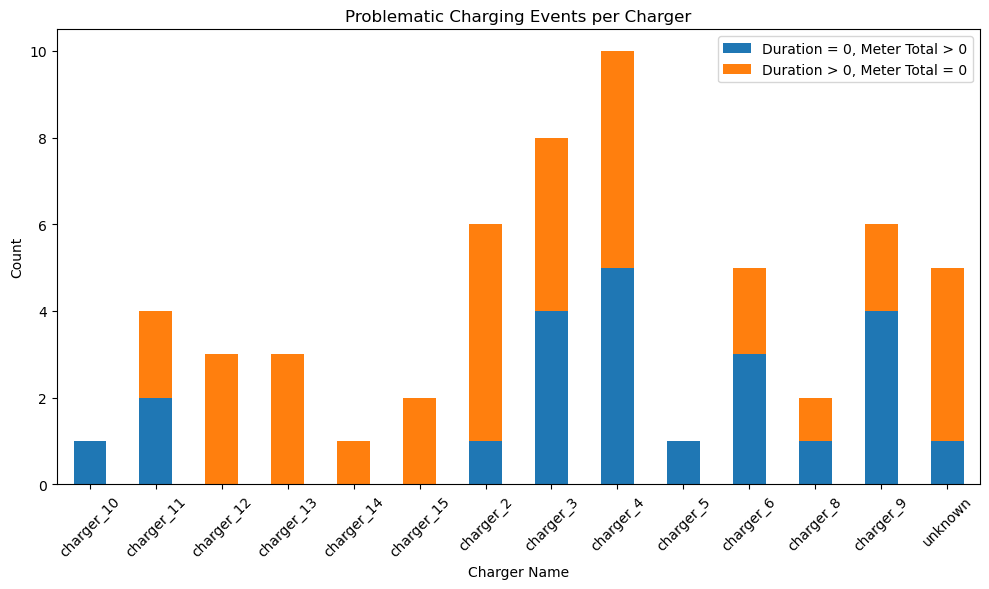

In [9]:
processor = ChargingDataProcessor(charging_events_df)
charging_events_df = processor.preprocess_data(remove_assumed_errors=True)

## Univariate Visuals

In [10]:
analyzer = UnivariateAnalyzer(charging_events_df)
analyzer.describe_numeric()

,Meter Start (kWh),Meter End (kWh),Meter Total (kWh),Total Duration (h)
count,220.000000,220.000000,220.000000,220.000000
mean,414.128200,421.512630,7.384430,25.388948
std,380.376547,377.449748,13.324386,84.966383
min,0.000000,0.116660,0.000000,0.000000
25%,81.072500,103.632995,0.036082,0.031042
50%,232.778000,239.262980,2.287920,3.088889
75%,753.246000,753.246000,7.871760,21.573403
max,1204.911000,1204.911000,126.350920,839.003056


In [11]:
analyzer.describe_categorical()

,Charger_name
count,220
unique,17
top,charger_4
freq,67


array([[<Axes: title={'center': 'Meter Start (kWh)'}>,
        <Axes: title={'center': 'Meter End (kWh)'}>],
       [<Axes: title={'center': 'Meter Total (kWh)'}>,
        <Axes: title={'center': 'Total Duration (h)'}>]], dtype=object)

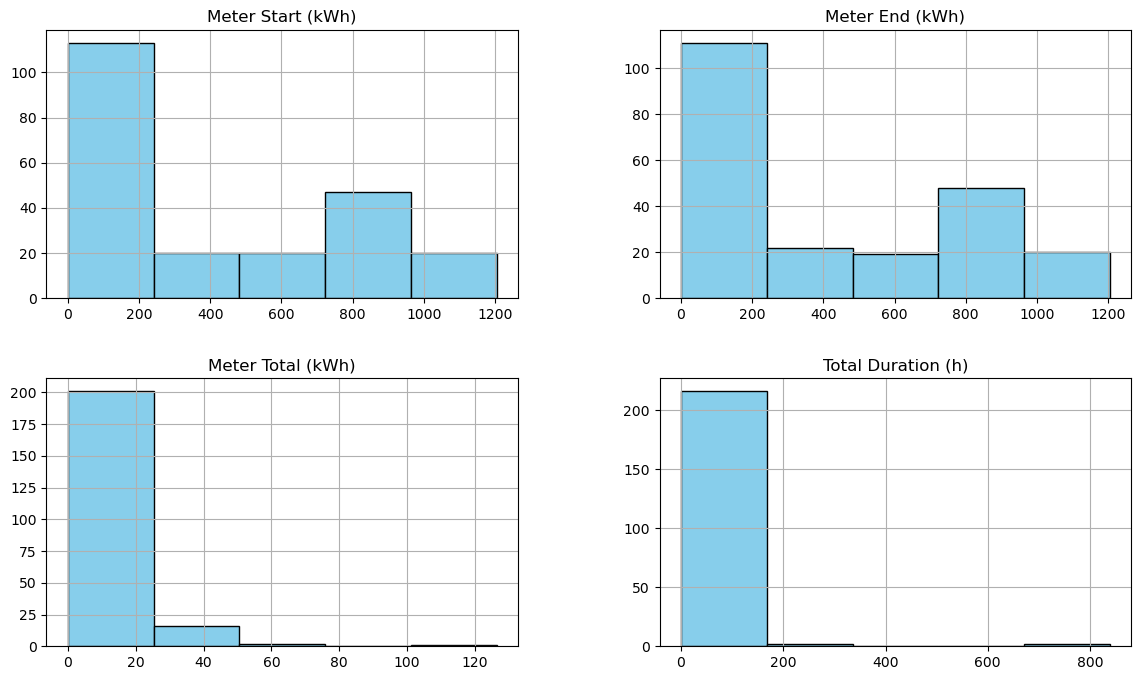

In [12]:
analyzer.plot_histograms()

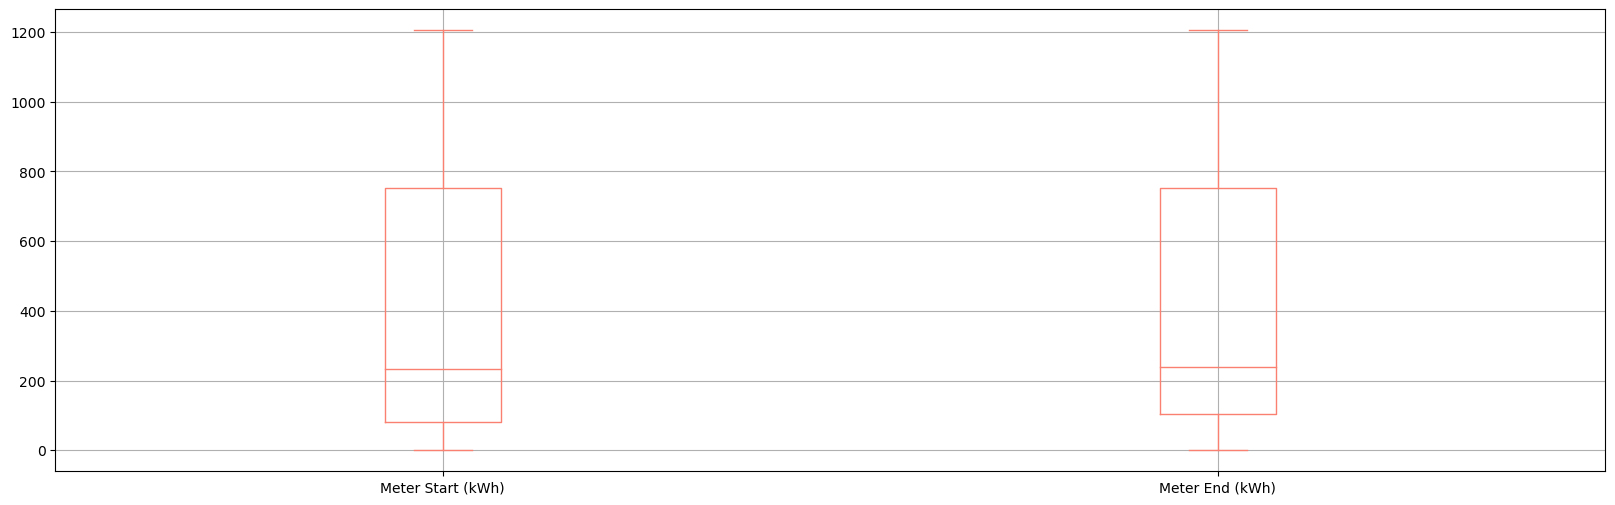

<Axes: >

In [13]:
analyzer.plot_boxplots_meter()

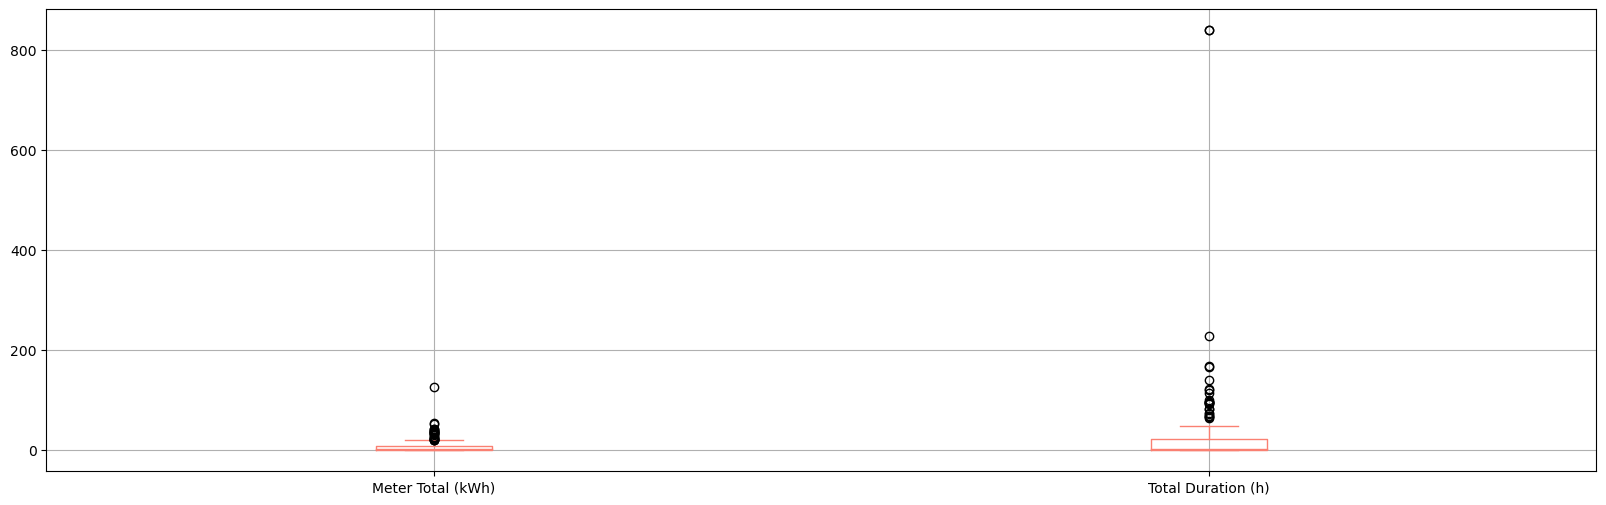

<Axes: >

In [14]:
analyzer.plot_boxplots_totals()

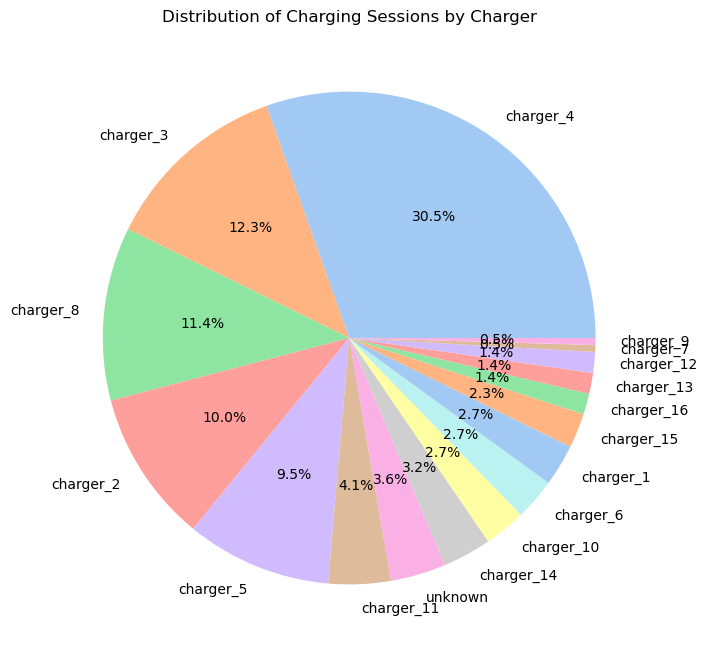

In [15]:
analyzer.plot_pie_chart()

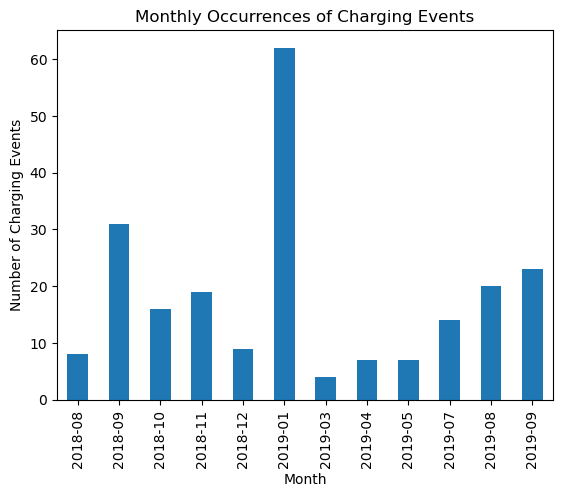

In [16]:
analyzer.plot_monthly_counts()

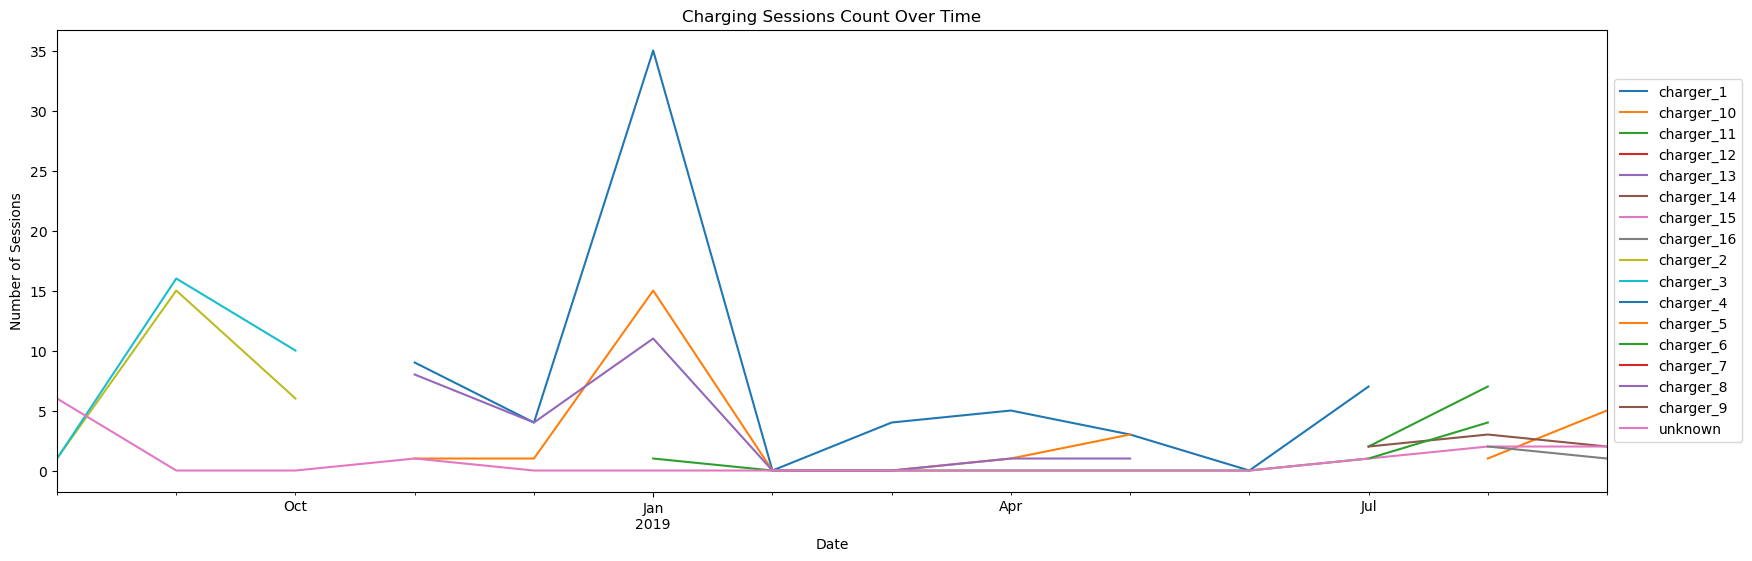

In [17]:
analyzer.plot_monthly_session_counts()

## Bivariate Visuals

In [18]:
bivariate_analyzer = BivariateAnalyzer(charging_events_df)

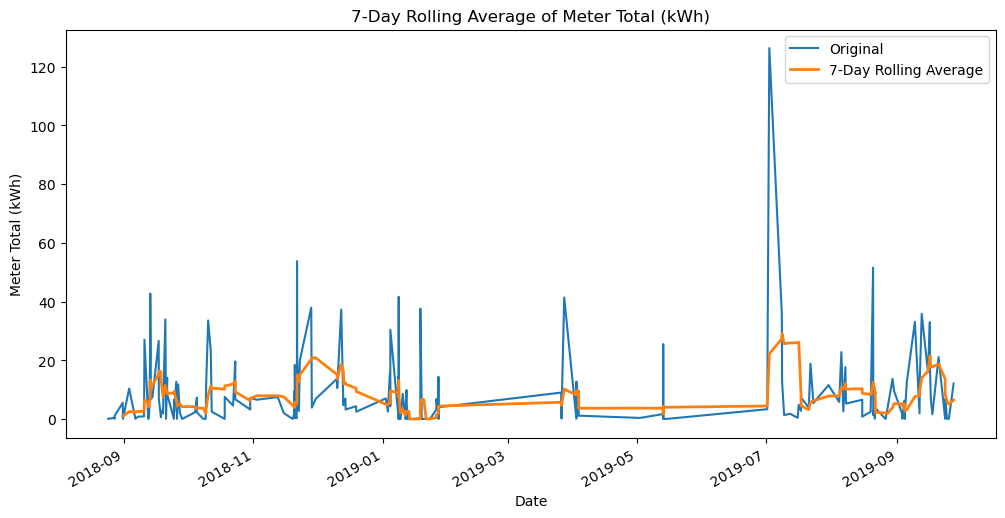

In [19]:
bivariate_analyzer.plot_rolling_average()

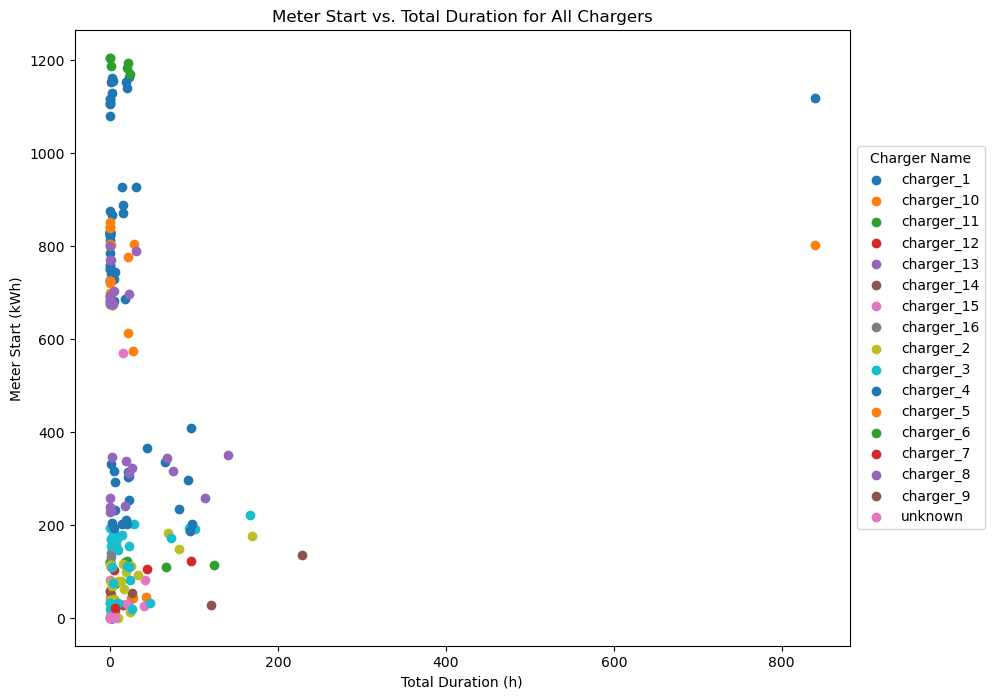

In [20]:
bivariate_analyzer.plot_start_duration_scatter()

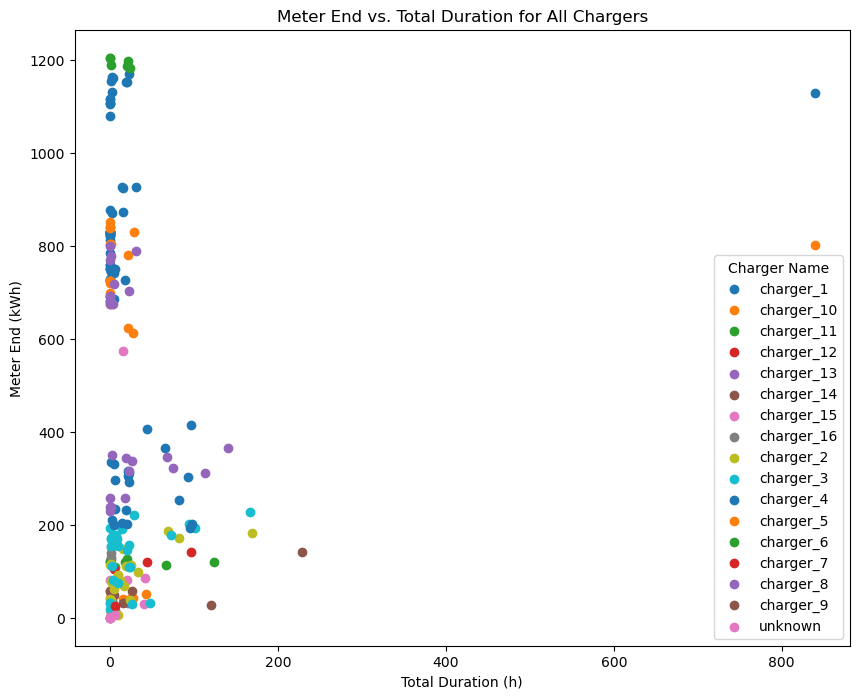

In [21]:
bivariate_analyzer.plot_end_duration_scatter()

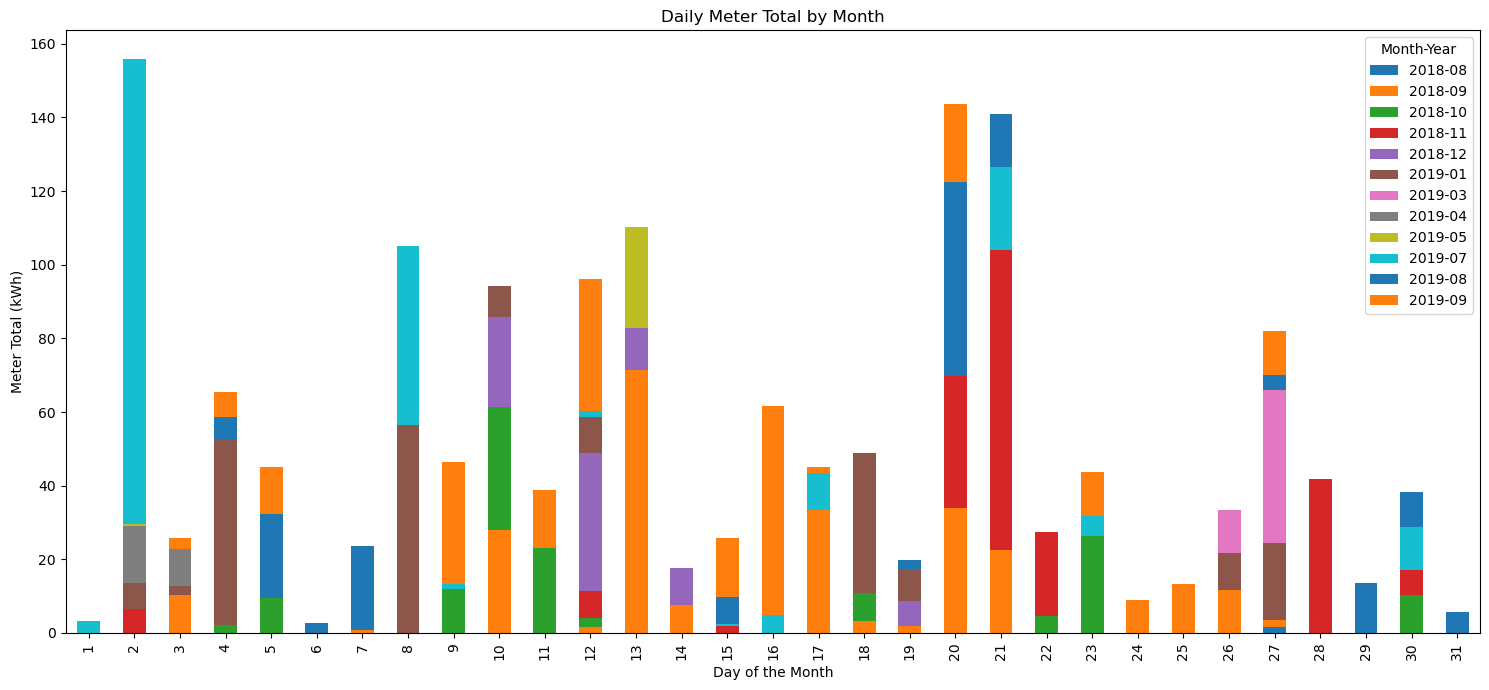

In [22]:
bivariate_analyzer.plot_daily_meter_month()

## Charger Specific Visuals

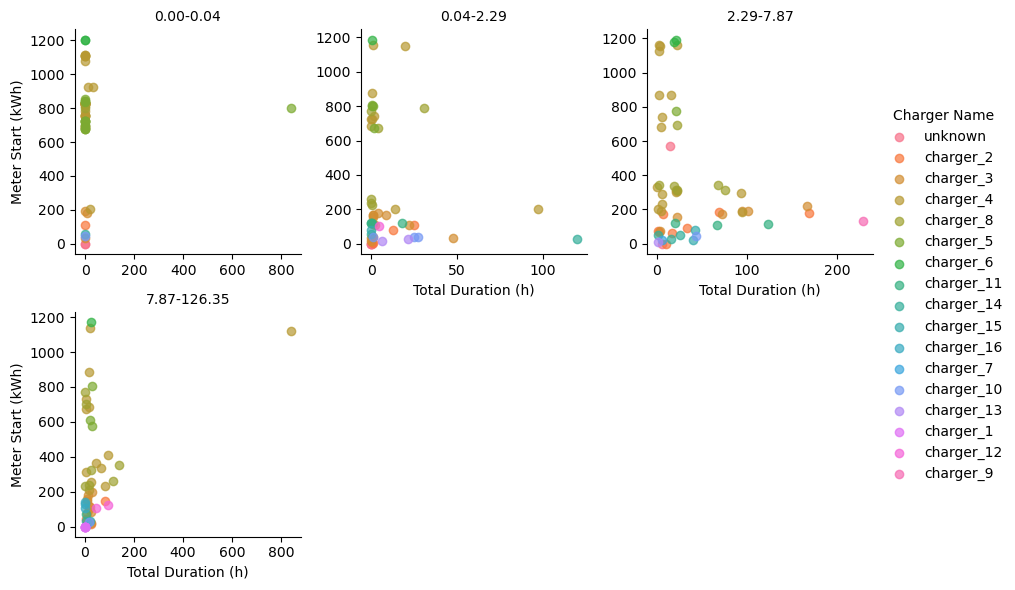

In [23]:
charger_analyzer = ChargerAnalyzer(charging_events_df)
bins = [0.00, 0.04, 2.29, 7.87, 126.35]
bin_labels = ['0.00-0.04', '0.04-2.29', '2.29-7.87', '7.87-126.35']
charger_analyzer.bin_meter_totals(bins, bin_labels)
charger_analyzer.plot_facetgrid_scatter()

In [24]:
charger_analyzer.perform_ancova()

ANCOVA for Meter Total Bin: (0.0361, 2.288]
                              sum_sq    df         F    PR(>F)
C(Q("Charger_name"))     5216.127125  12.0  0.871168  0.581177
Q("Meter Start (kWh)")   1293.701415   1.0  2.592800  0.115024
Residual                20457.331025  41.0       NaN       NaN


ANCOVA for Meter Total Bin: (-0.001, 0.0361]
                               sum_sq    df         F    PR(>F)
C(Q("Charger_name"))     39432.999087   7.0  0.398420  0.898363
Q("Meter Start (kWh)")     815.578487   1.0  0.057683  0.811264
Residual                650396.375221  46.0       NaN       NaN


ANCOVA for Meter Total Bin: (2.288, 7.872]
                              sum_sq    df         F    PR(>F)
C(Q("Charger_name"))    55570.438876  13.0  2.690784  0.008179
Q("Meter Start (kWh)")    495.058880   1.0  0.311627  0.579795
Residual                63545.031798  40.0       NaN       NaN


ANCOVA for Meter Total Bin: (7.872, 126.351]
                               sum_sq    df         F    

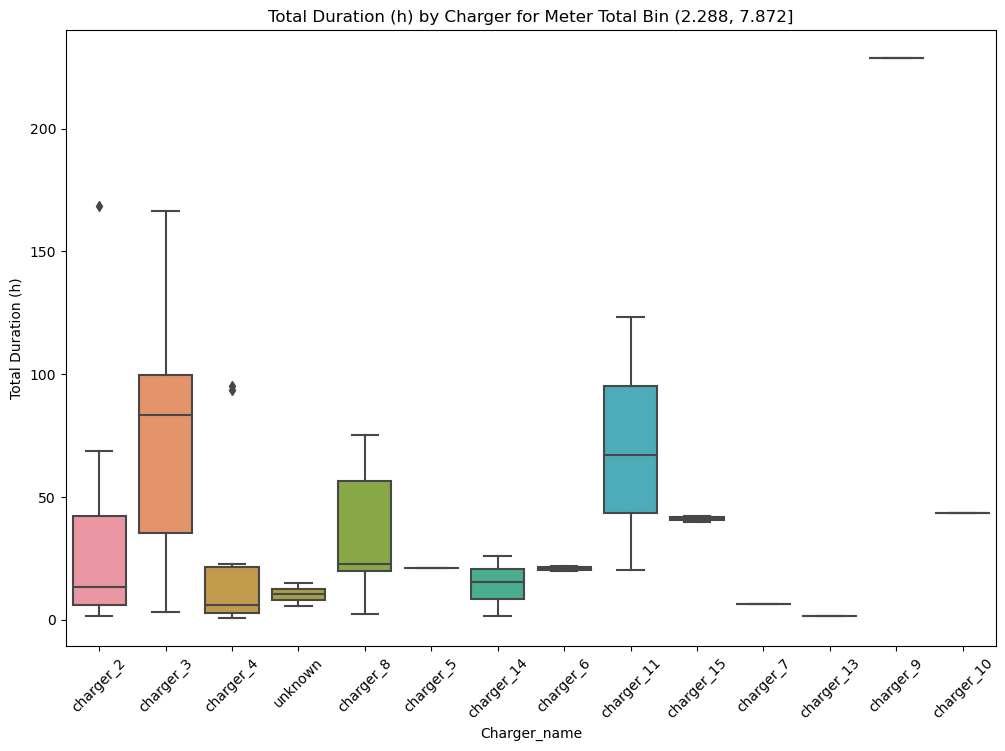

In [25]:
# If outliers are removed use this range (remove_assumed_errors=True, remove_outliers=True)
#charger_analyzer.plot_bin_boxplot('(2.011, 7.145]')

# If assumed malfunctions are included use this range (remove_assumed_errors=False, remove_outliers=False)
# charger_analyzer.plot_bin_boxplot('(6.822, 126.351]')

charger_analyzer.plot_bin_boxplot('(2.288, 7.872]') # Default

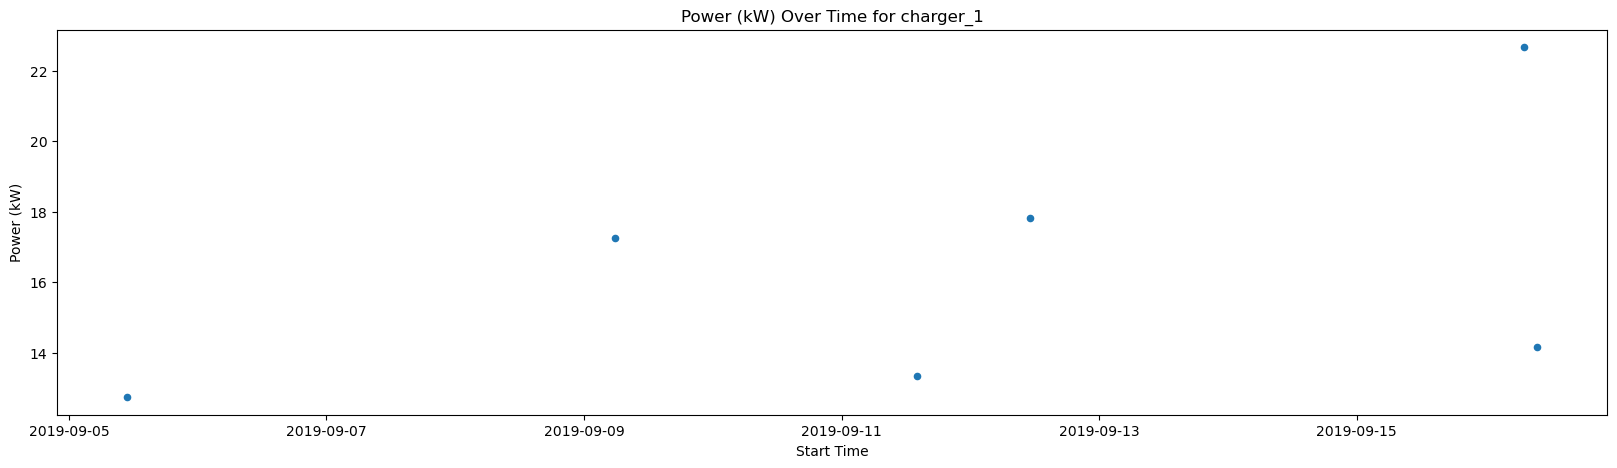

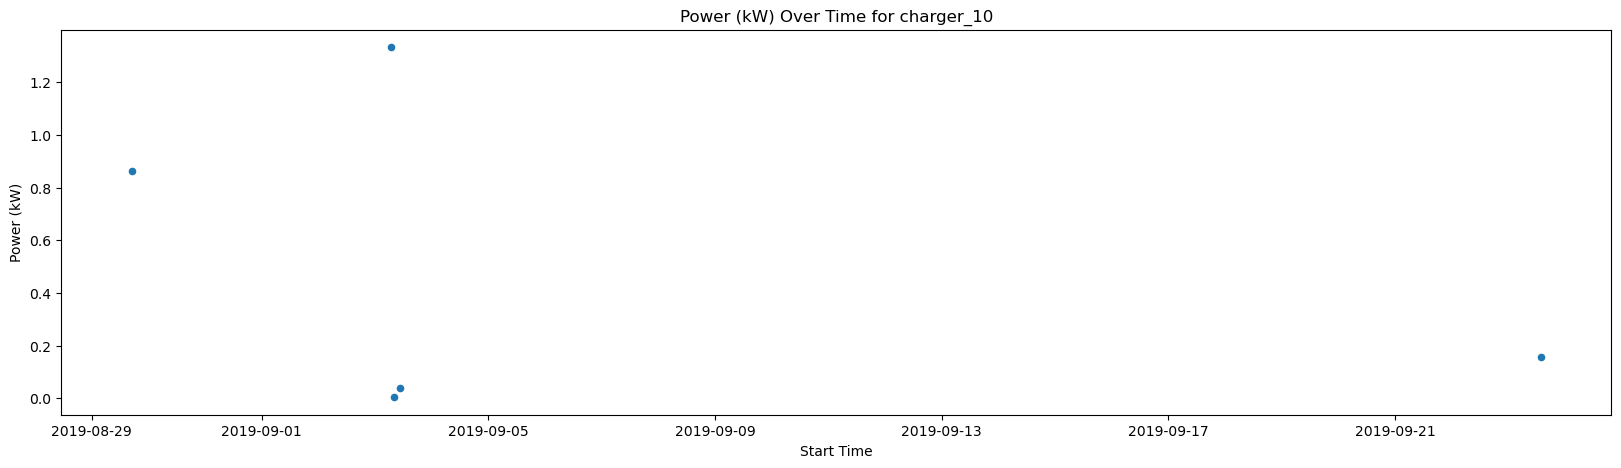

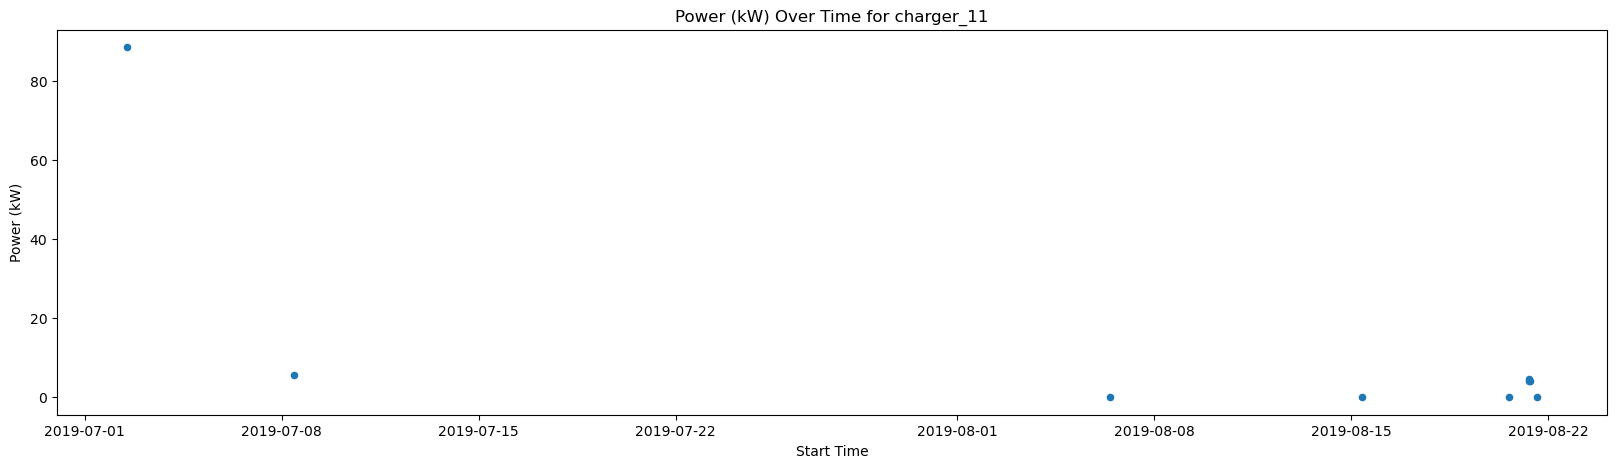

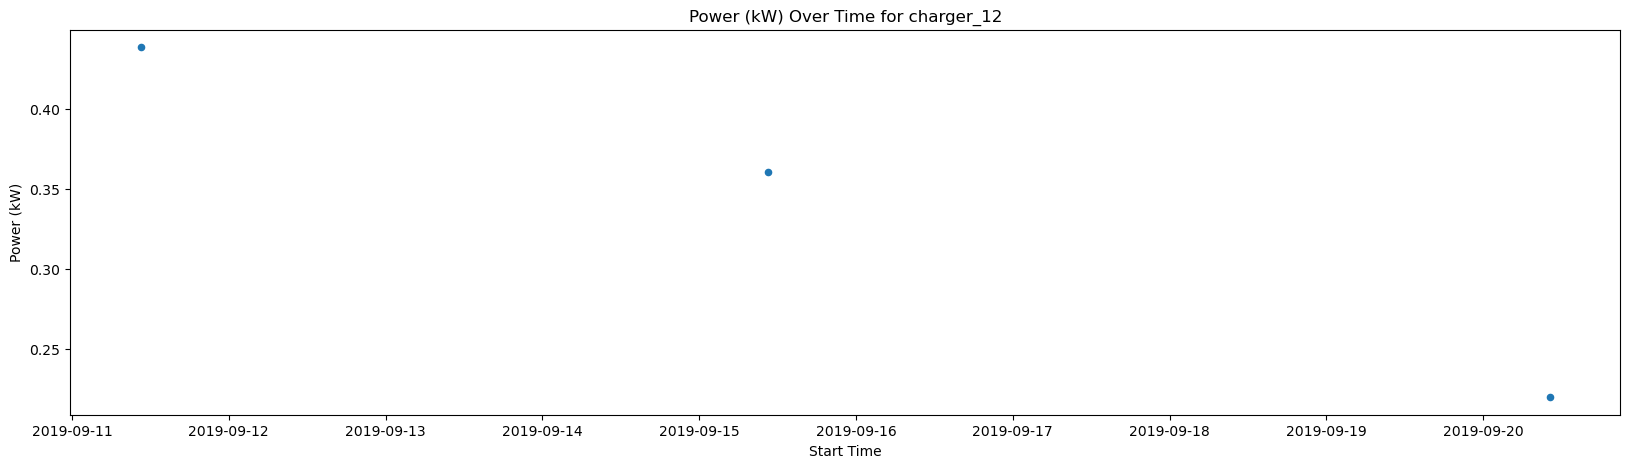

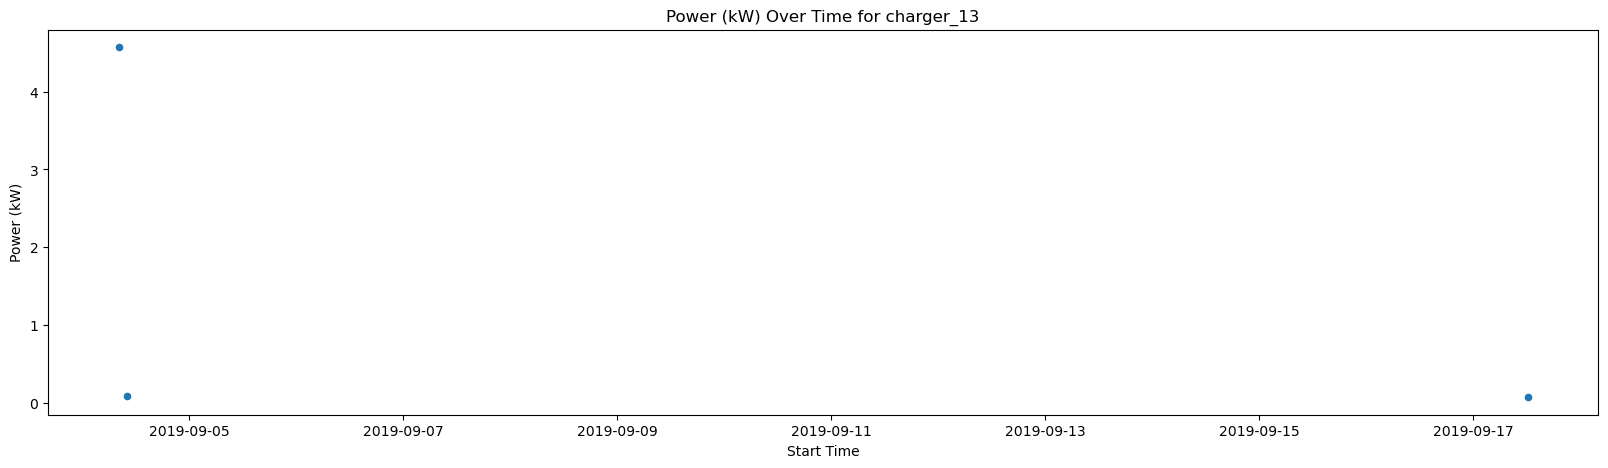

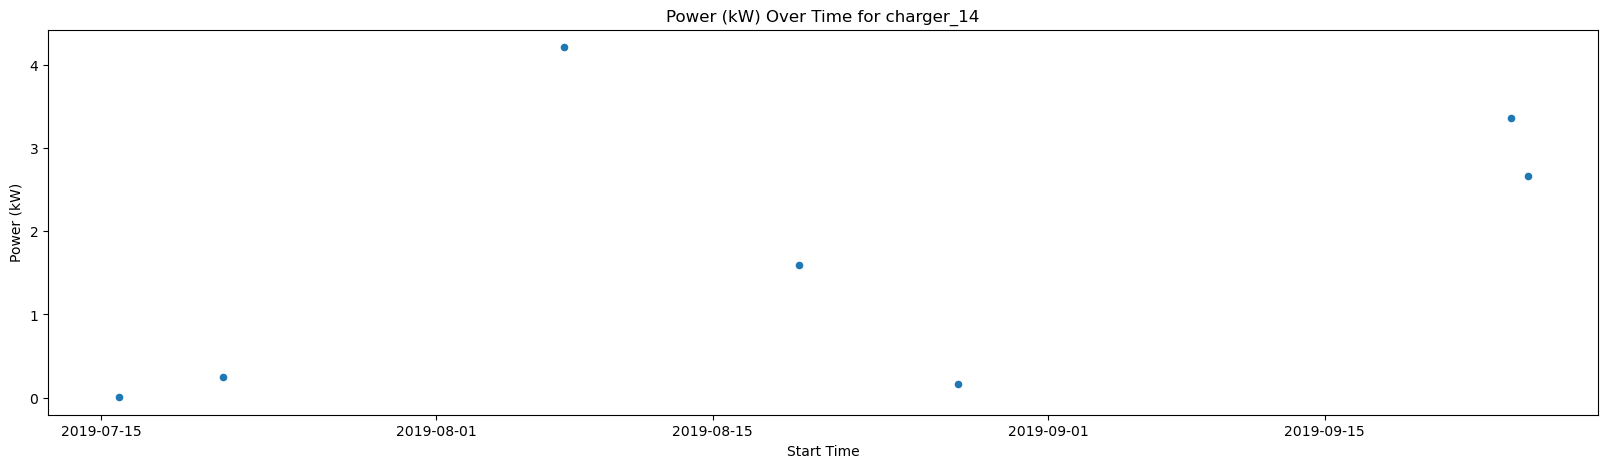

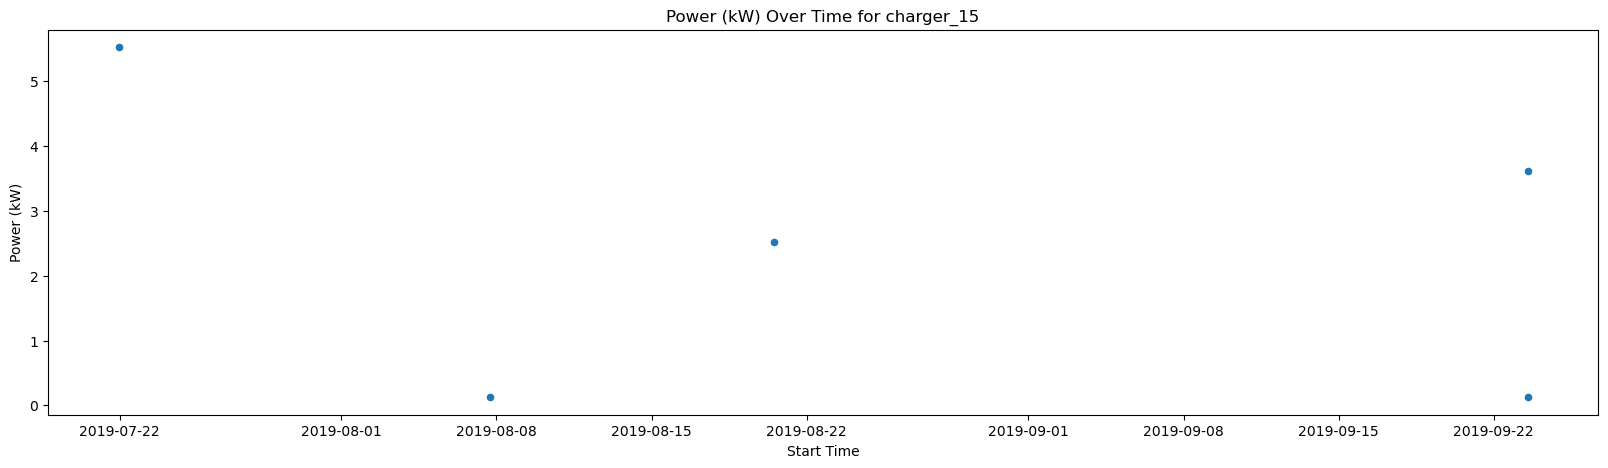

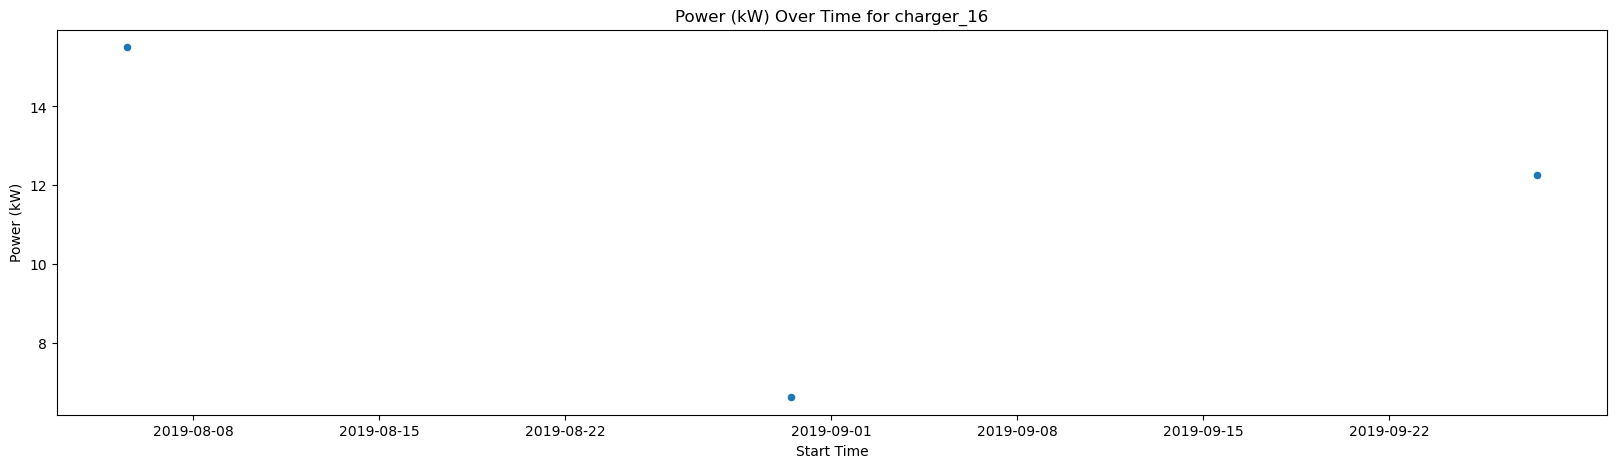

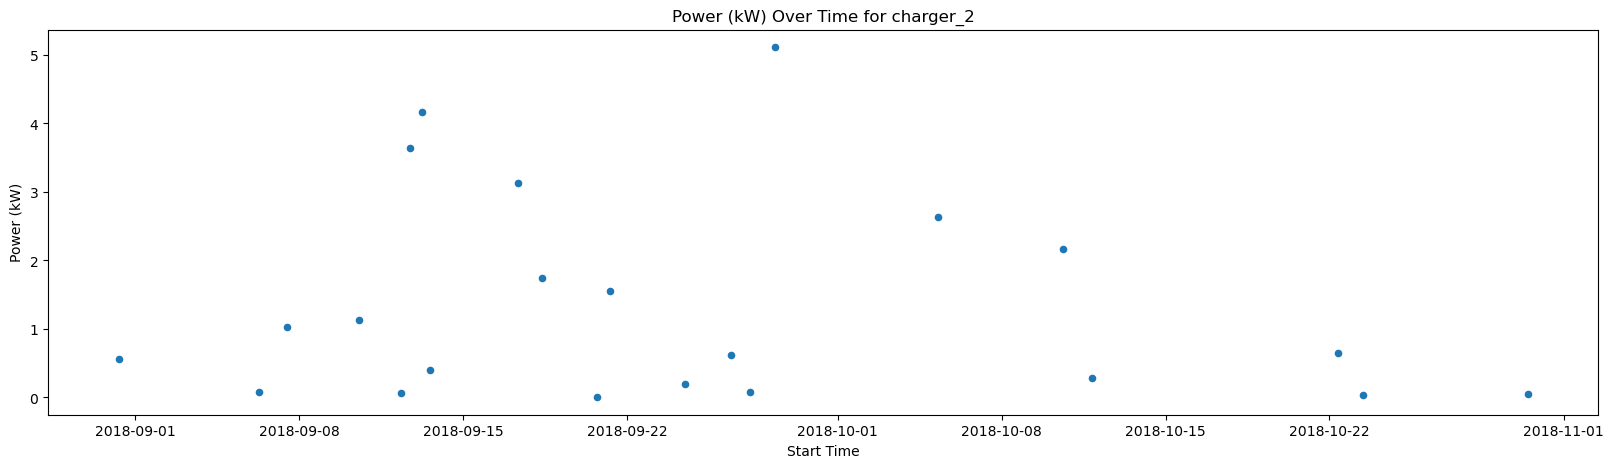

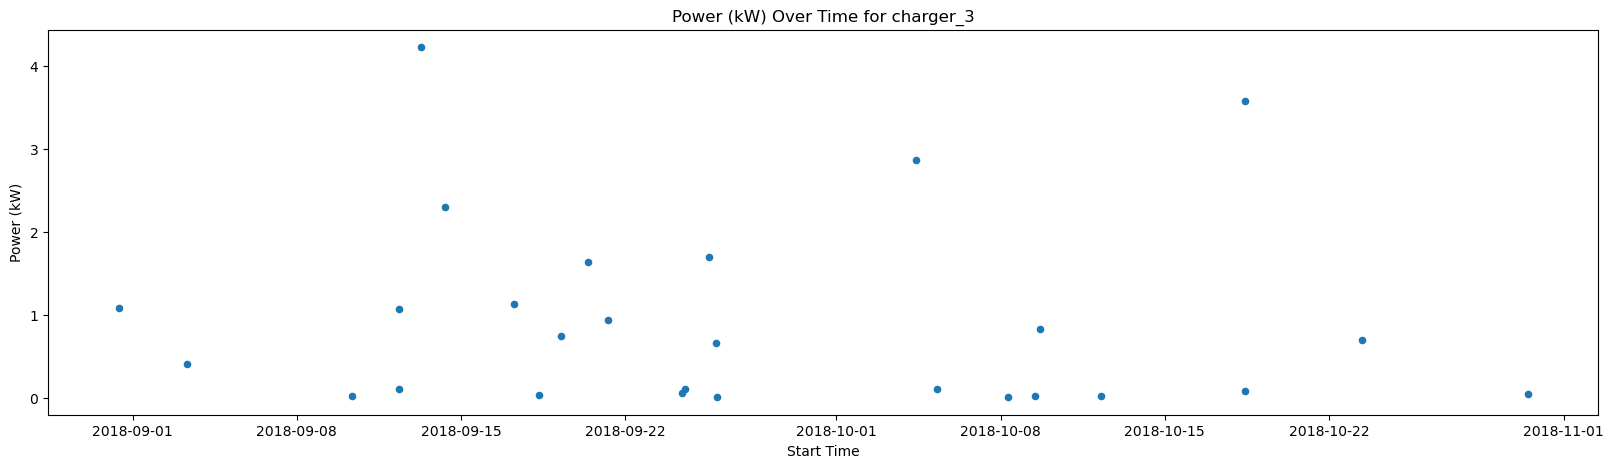

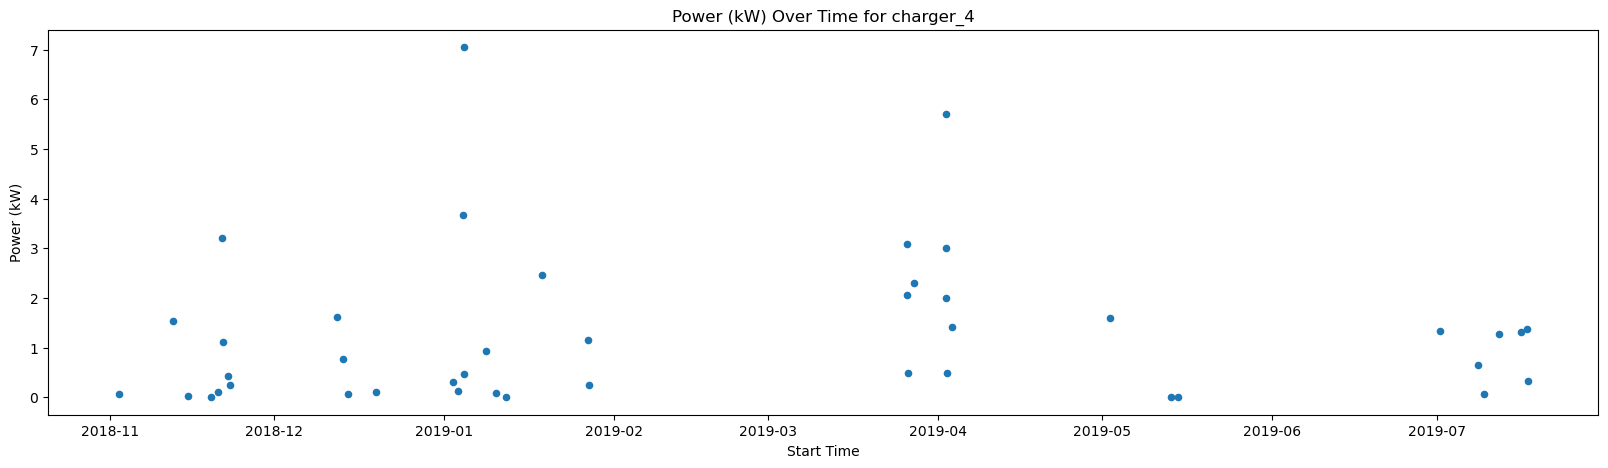

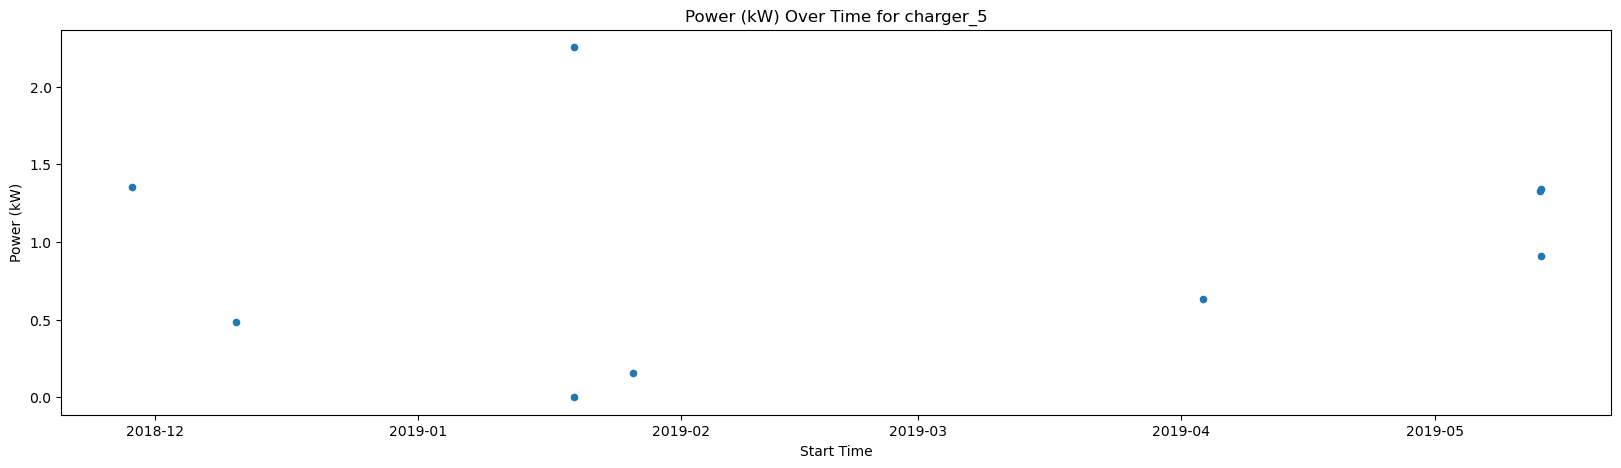

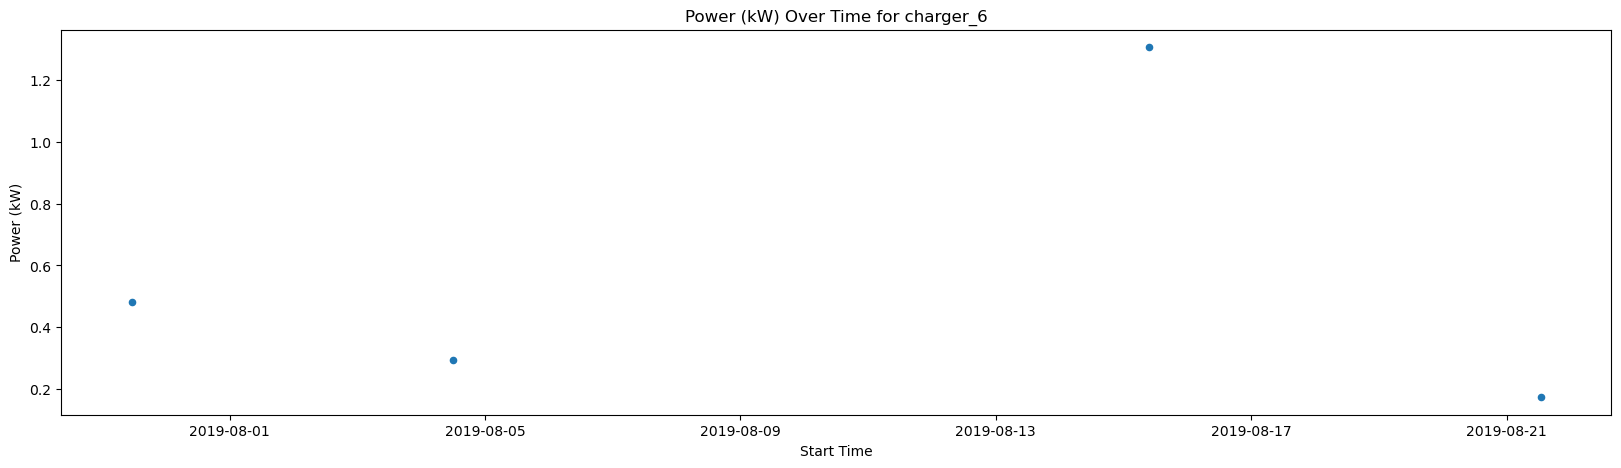

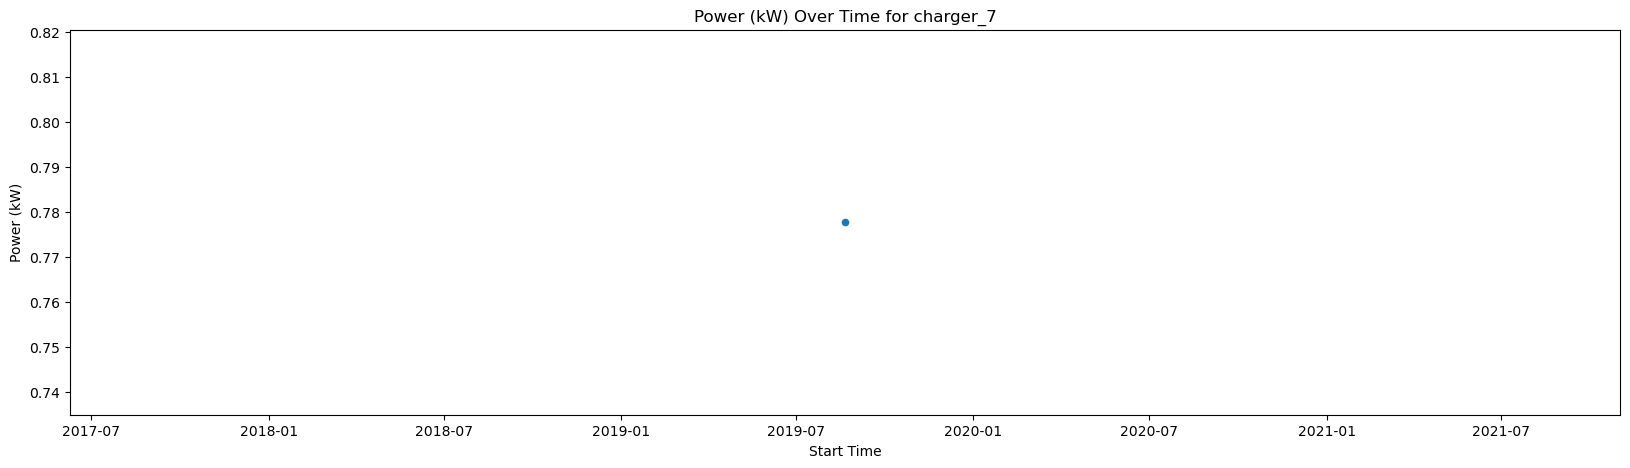

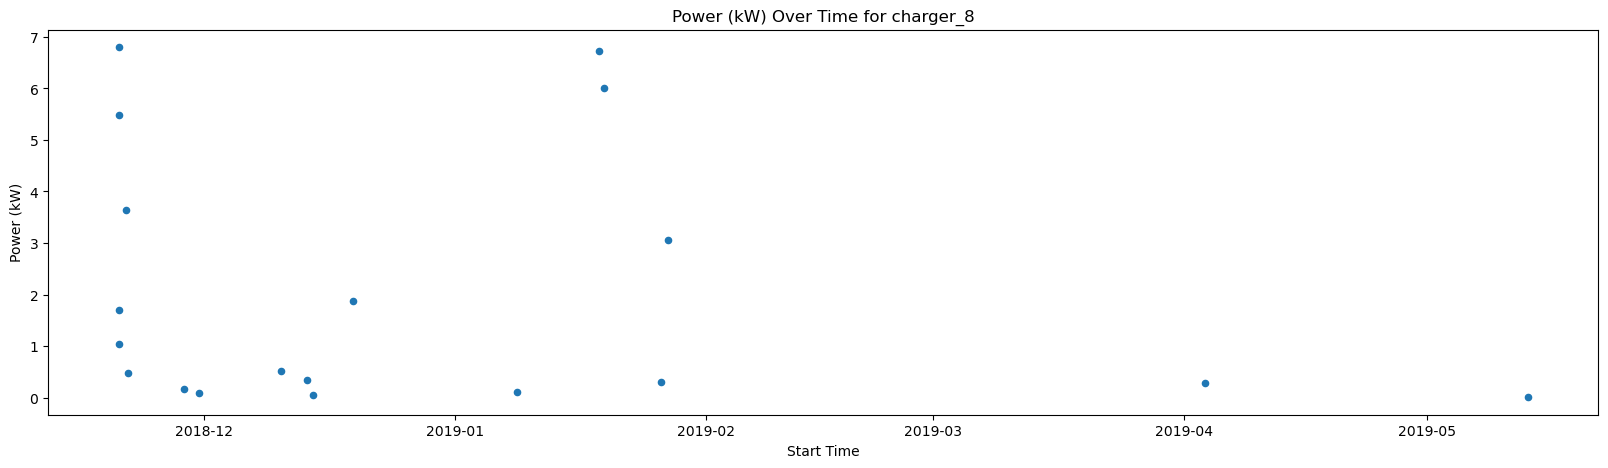

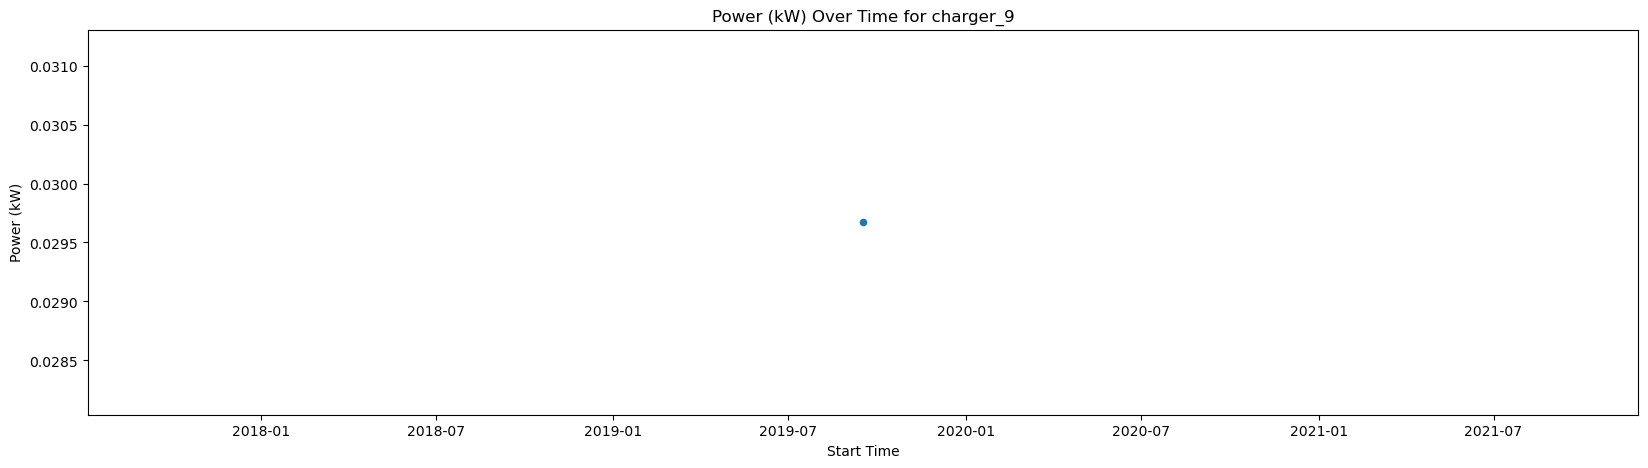

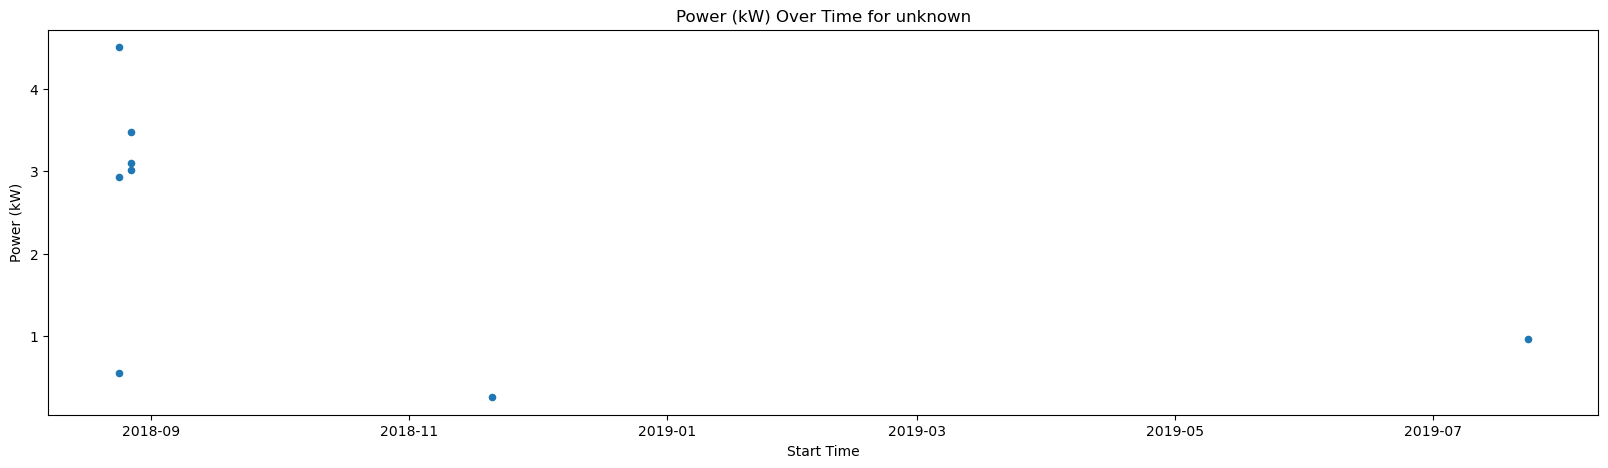

In [26]:
charger_analyzer.plot_power_over_time()

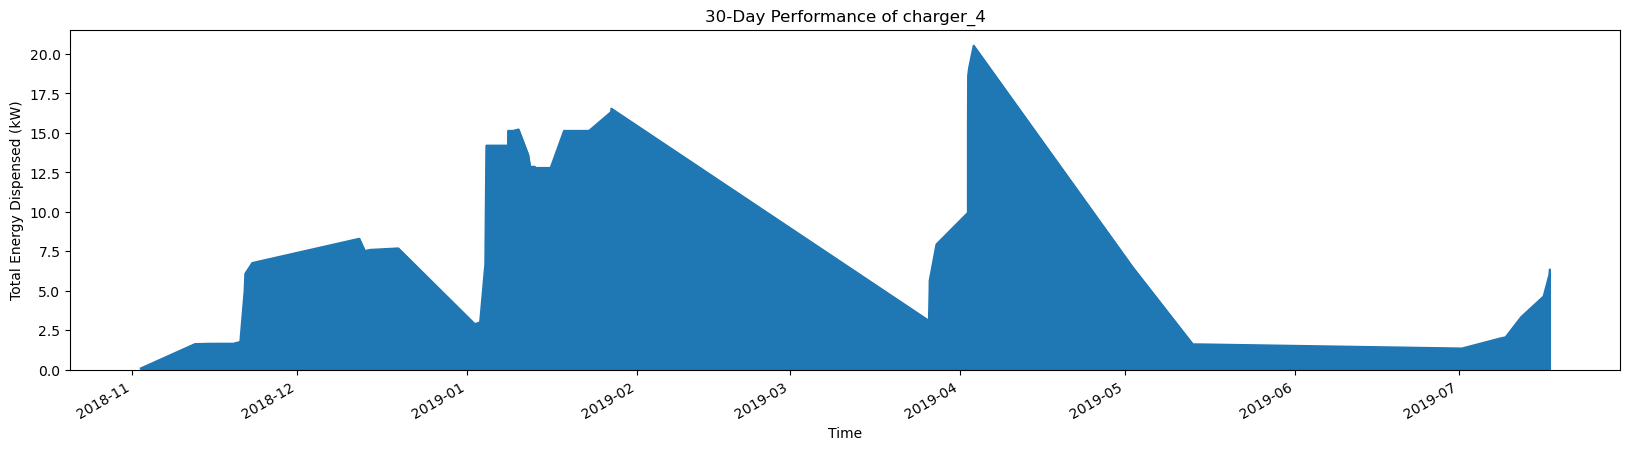

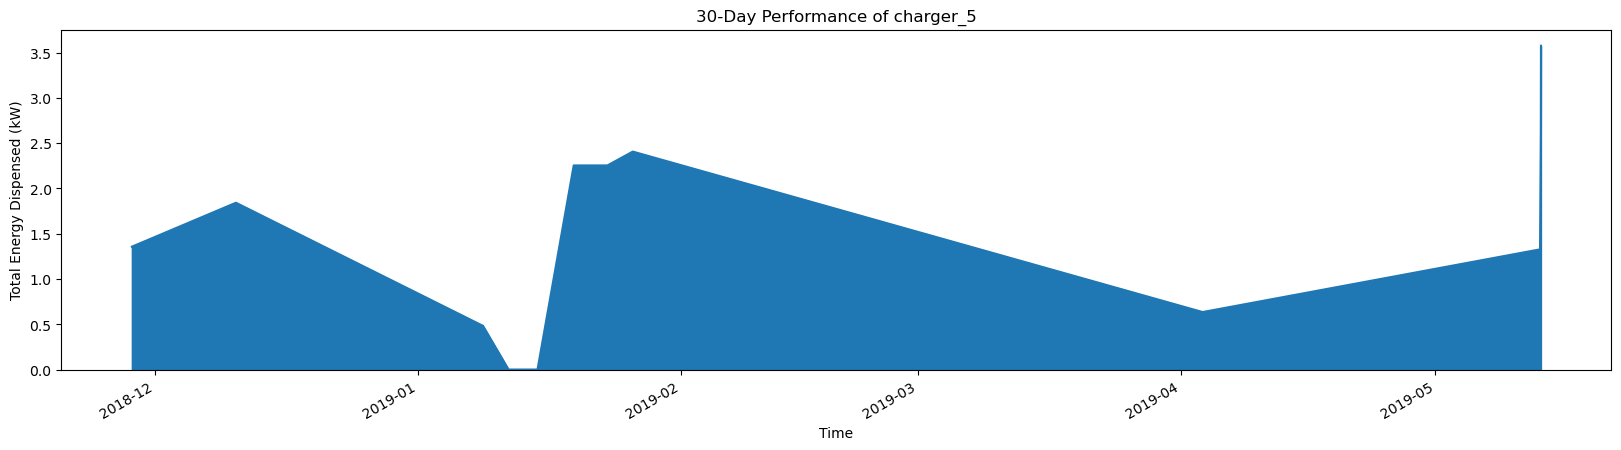

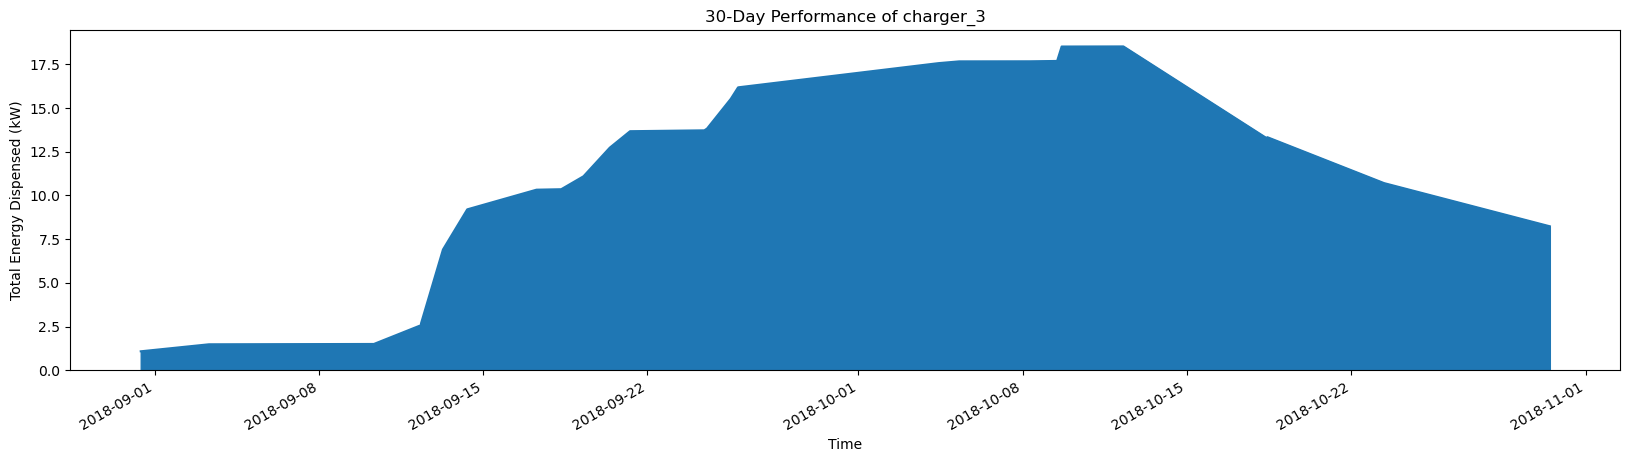

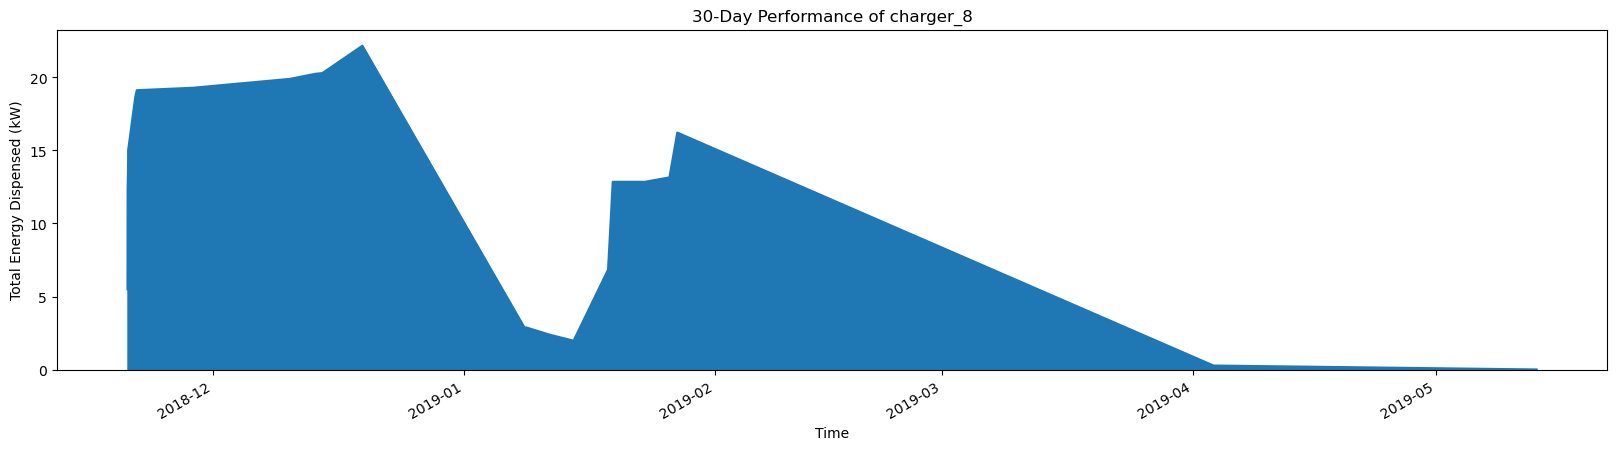

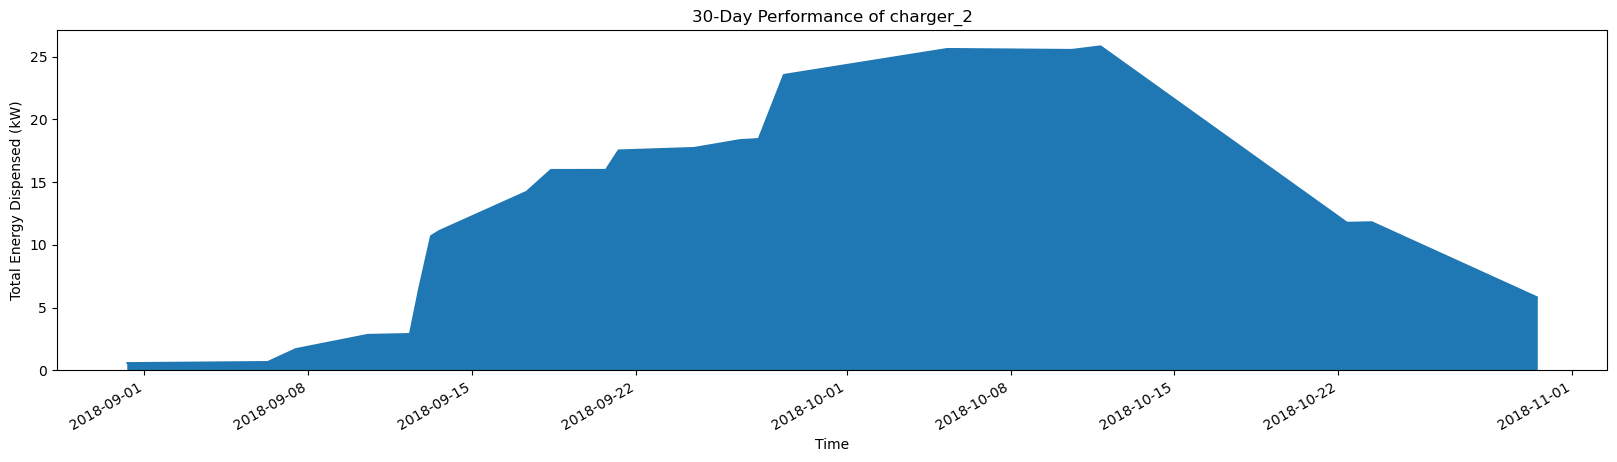

In [27]:
charger_analyzer.plot_30_day_performance()

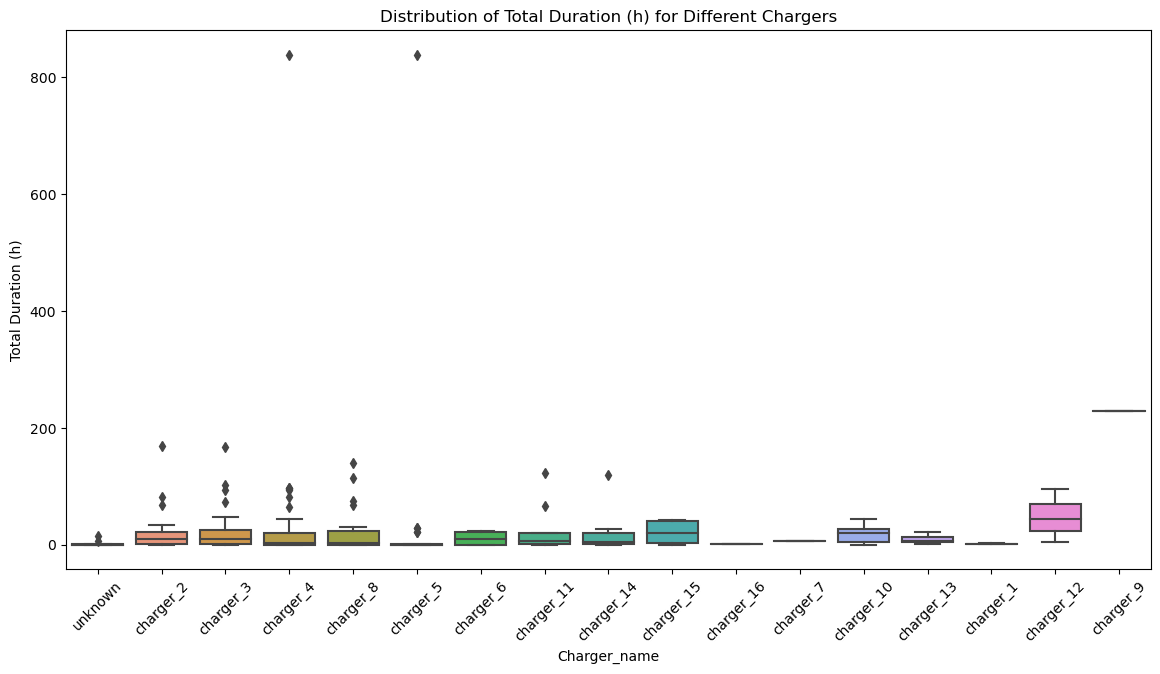

In [28]:
charger_analyzer.plot_total_duration_boxplot()

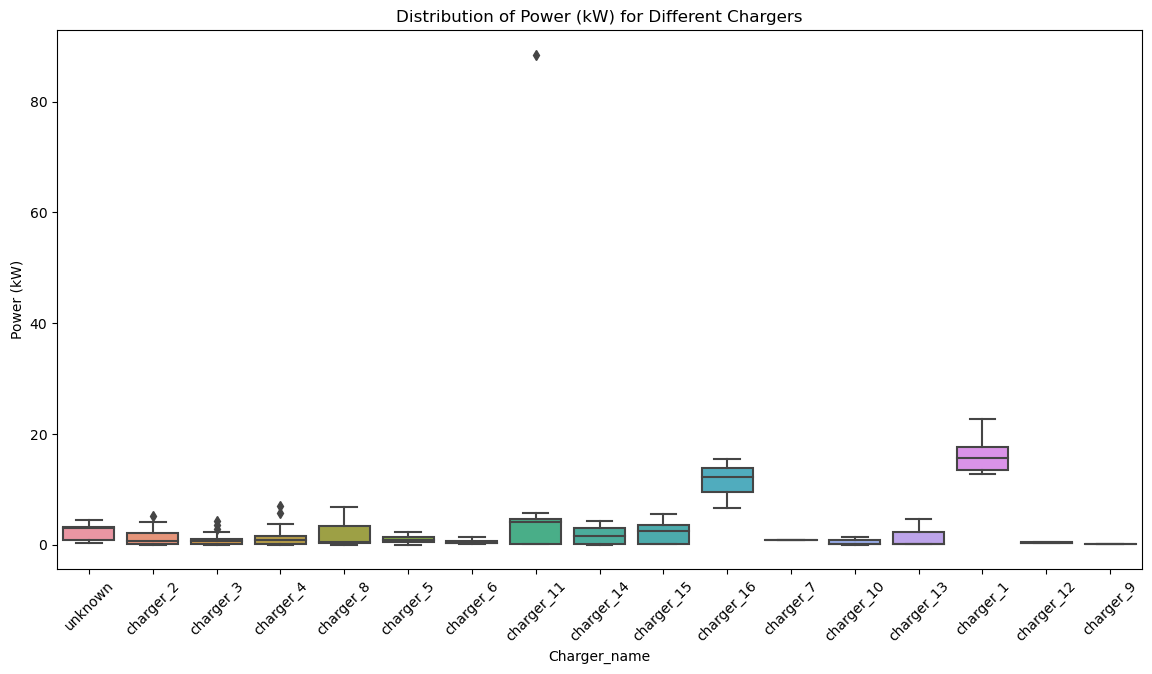

In [29]:
charger_analyzer.plot_power_boxplot()

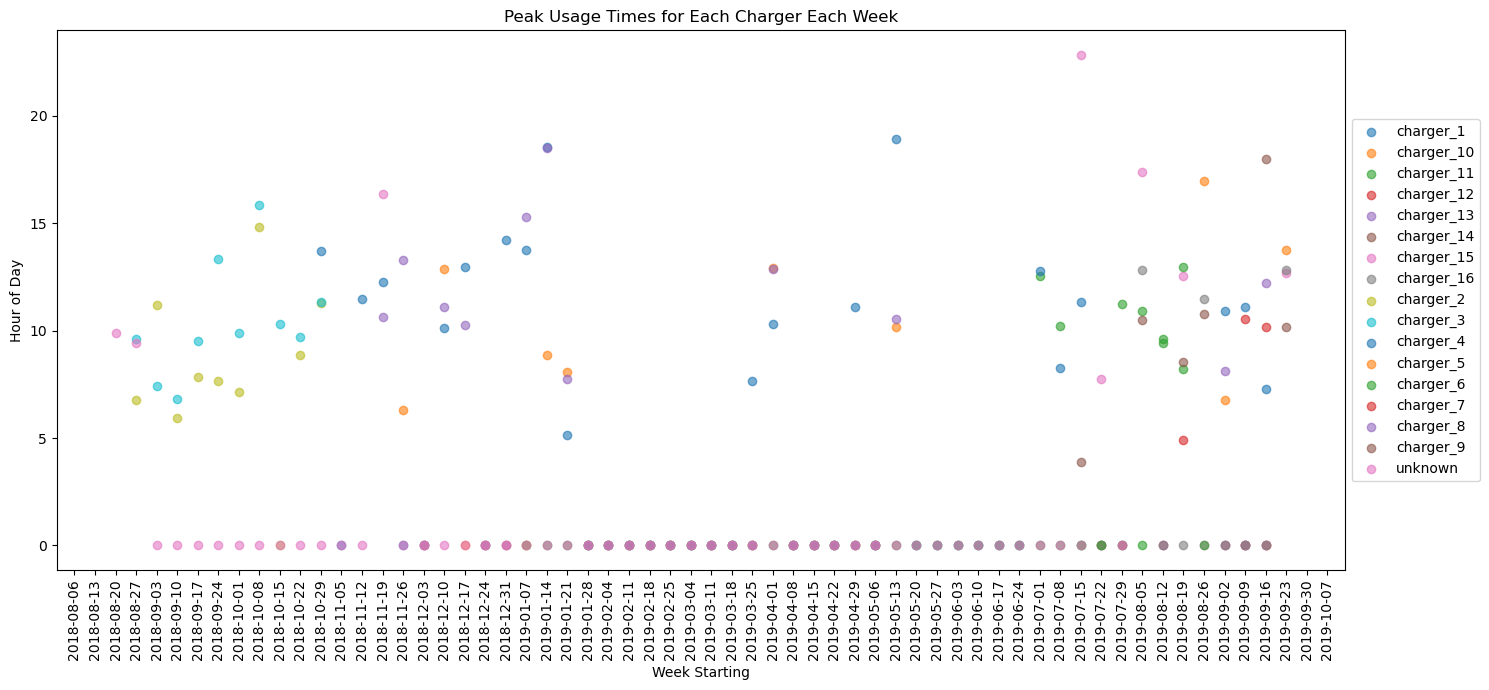

In [30]:
weekly_stats = charger_analyzer.calculate_weekly_statistics()
charger_analyzer.plot_peak_usage_times(weekly_stats)

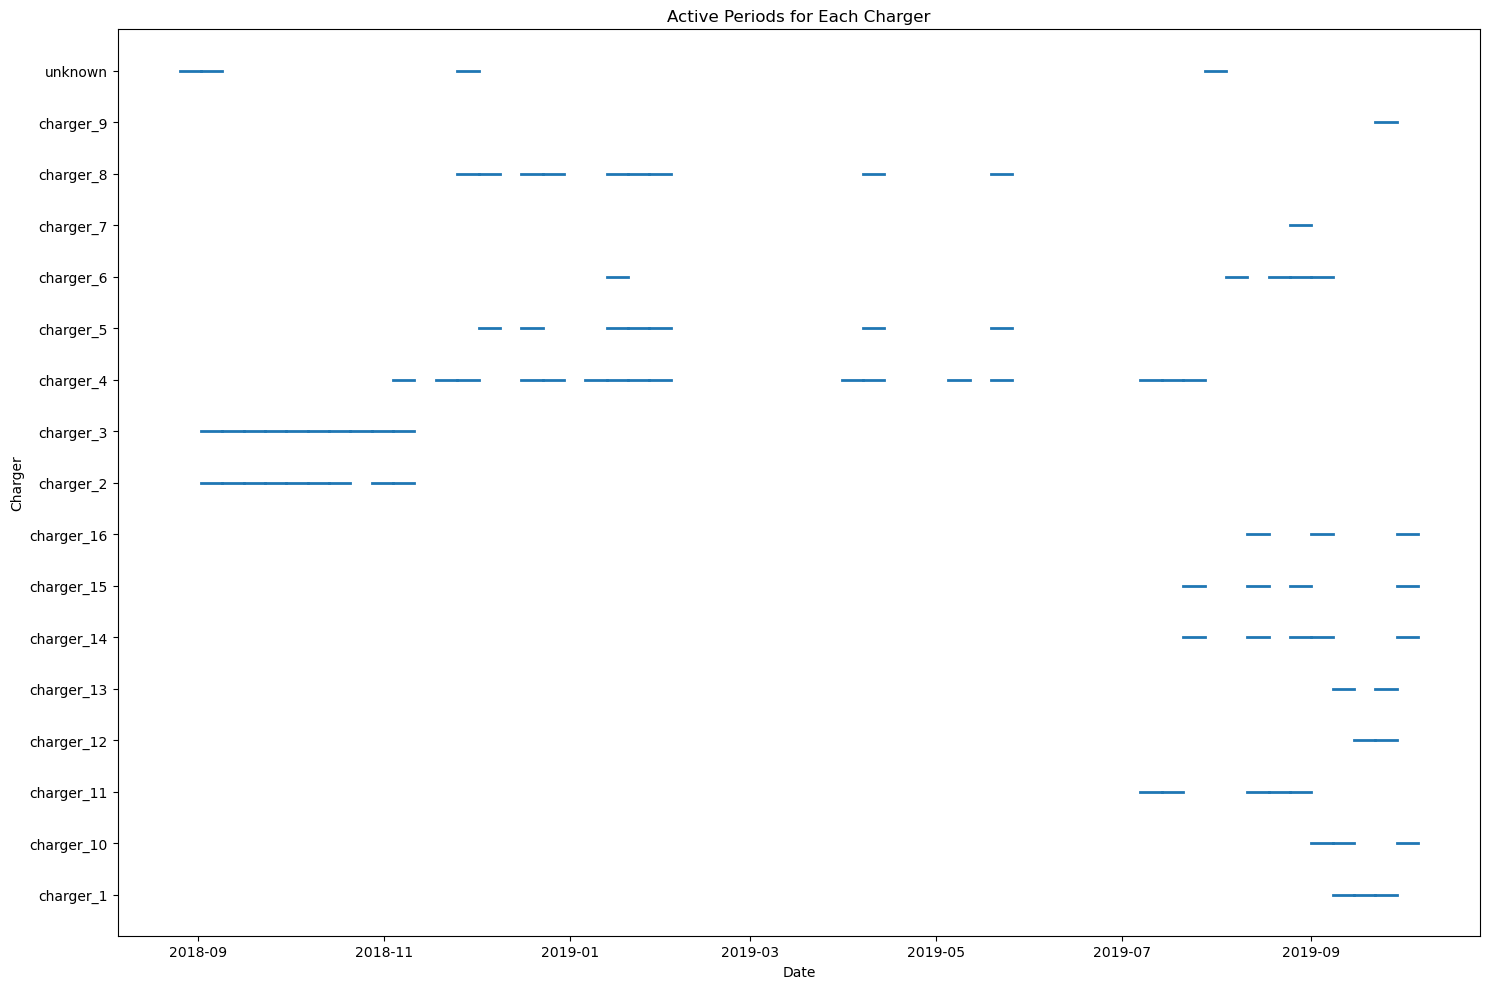

In [31]:
charger_analyzer.plot_active_periods(weekly_stats)

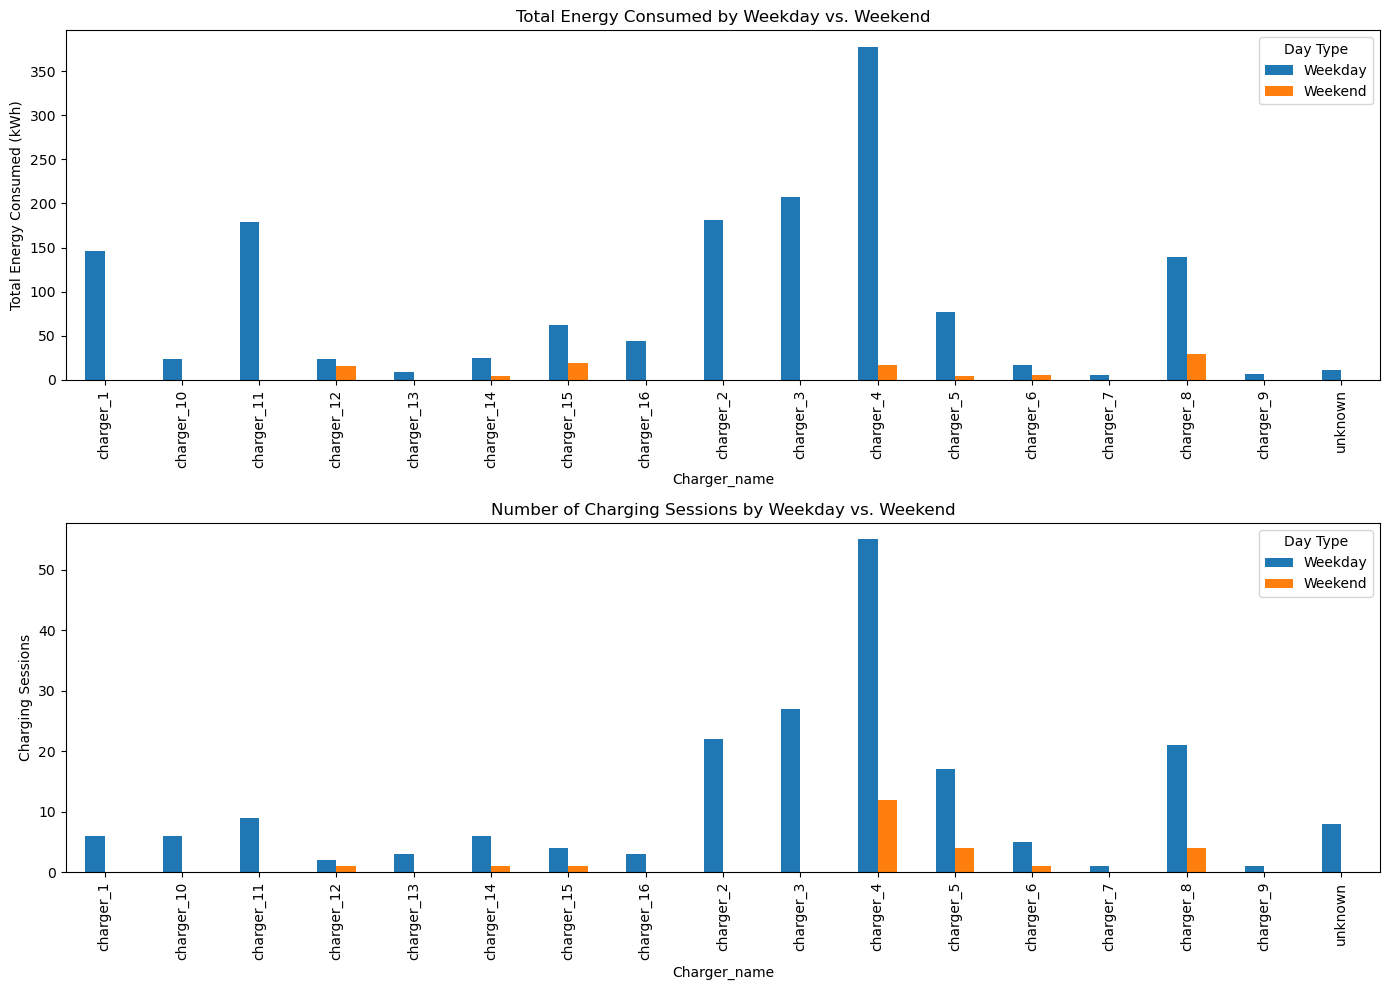

In [32]:
charger_analyzer.plot_energy_and_sessions_by_day_type()

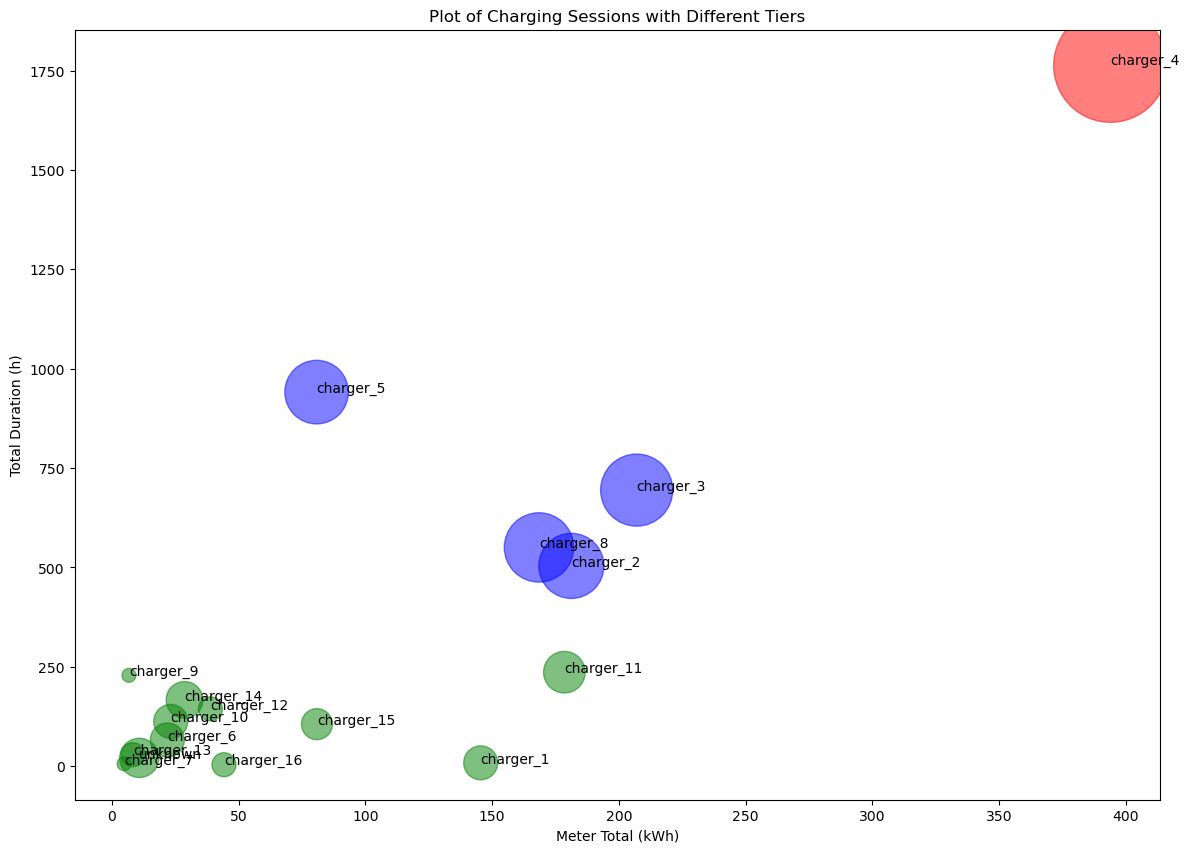

In [33]:
charger_analyzer.plot_tiered_bubble_chart()

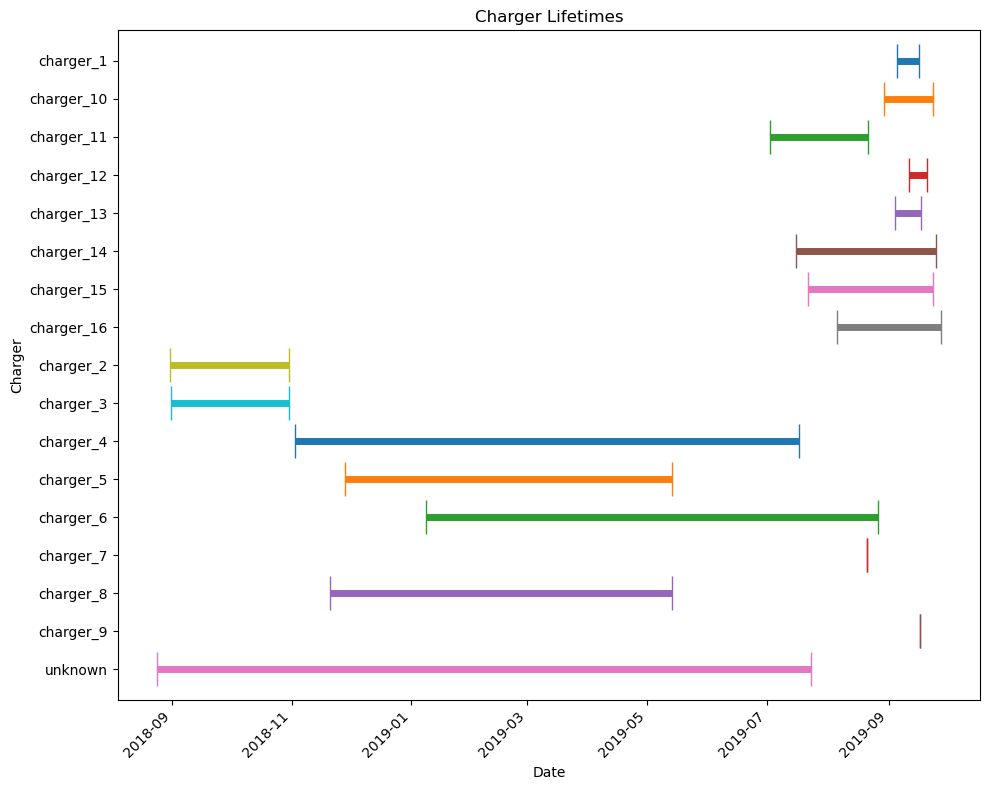

In [34]:
charger_analyzer.plot_charger_lifetime()